# Прогноз оттока клиентов

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.Даны данные о поведении клиентов и расторжении договоров с банком. 

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

### План работ

 1. Загрузите и подготовьте данные.
 2. Исследуйте баланс классов, обучите модель без учёта дисбаланса.
 3. Улучшите качество модели, учитывая дисбаланс классов.
 4. Проведите финальное тестирование.
 

In [1]:
from tqdm import notebook

# 1. Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from sklearn.preprocessing import binarize, StandardScaler 
from sklearn.utils import shuffle #перемешивает данные
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, \
                             GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, recall_score,\
                            precision_score, f1_score,\
                            accuracy_score,\
                            precision_recall_curve,\
                            roc_curve, roc_auc_score

In [2]:
sns.set_style('whitegrid', {'grid.linestyle':'--'})
pd.set_option("display.max_columns",100)

In [5]:
data_churn = pd.read_csv('datasets/Churn.csv') 

In [6]:
data_churn

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


Столбецы RowNumber,CustomerId и Surname можно удалить. Они не повлияют на исследование. А если и повлияют, то это не здорОво.

In [6]:
data_churn = data_churn.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
data_churn

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


In [7]:
data_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


Нужно: 
 1. заполнить пропуск в столбце с недвижимостью (Tenure) нулями, так как лигично предположить, что пропуск означает отсутсвие;
 2. избавиться от категориальных признаков типа object.
 
Первый пункт.

In [8]:
data_churn['Tenure'] = data_churn['Tenure'].fillna(0)
data_churn['Tenure'].value_counts(dropna=True).sum()

10000

Второй пункт.

In [12]:
data_churn = pd.get_dummies(data_churn, drop_first=True)

Глянем на баланс классов.

In [13]:
print('Клиентов, покинувших банк:', data_churn[data_churn['Exited'] == 1].shape[0])
print('Клиентов, не покинувших банк:', data_churn[data_churn['Exited'] == 0].shape[0])

Клиентов, покинувших банк: 2037
Клиентов, не покинувших банк: 7963


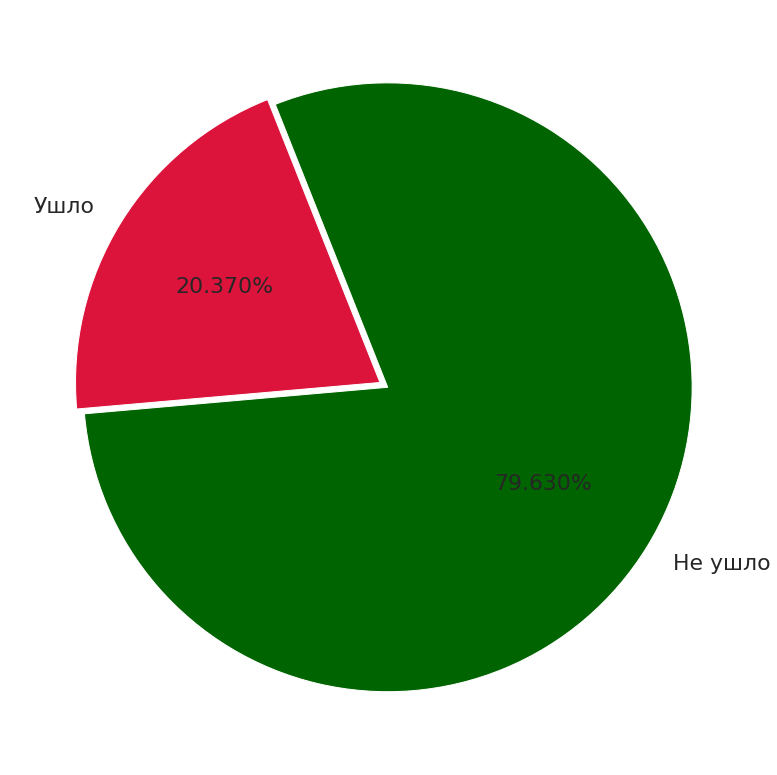

In [14]:
fig, ax = plt.subplots(figsize=(14,14))
data_churn['Exited'].value_counts().plot.pie(ax=ax, 
                                             colors=['darkgreen', 'crimson'], 
                                             explode=(0,0.03), 
                                             startangle=185, 
                                             autopct='%.3f%%', 
                                             fontsize=22,
                                             labels=['Не ушло','Ушло'])
plt.xlabel('')
plt.ylabel('')
plt.show()

Датасет является несбалансированными. Стоит задача обучить модель без изменения баланса классов, поэтому к этому мы вернемся позже. 

Глянем на распределение признаков.

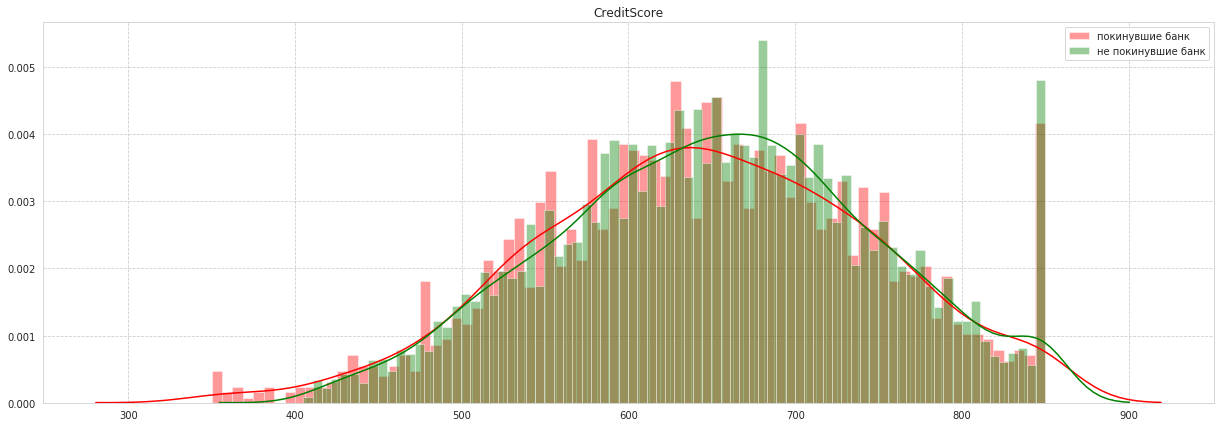

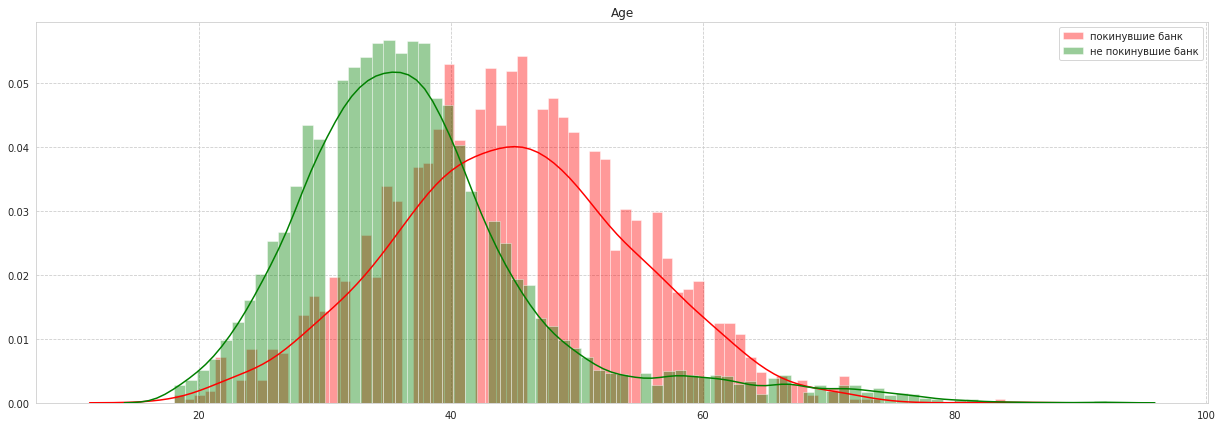

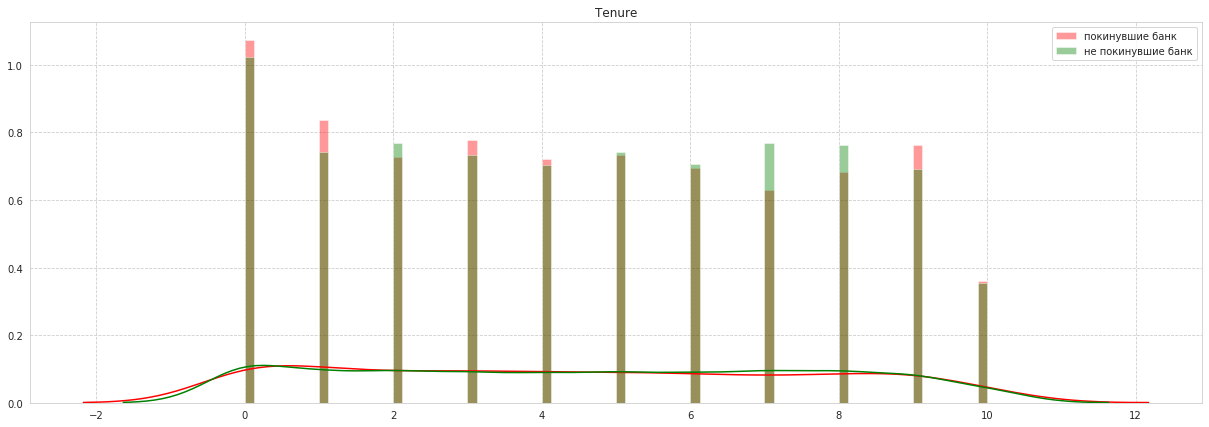

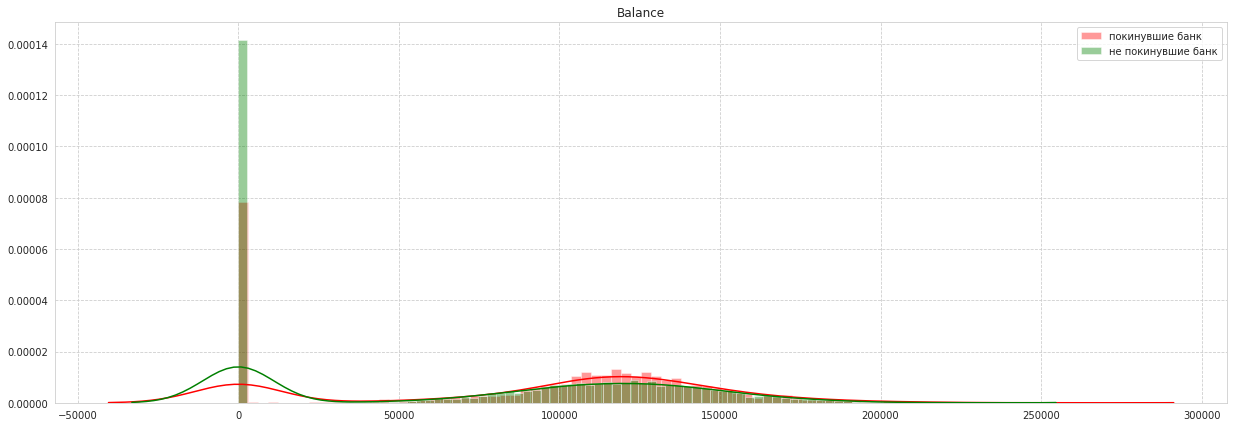

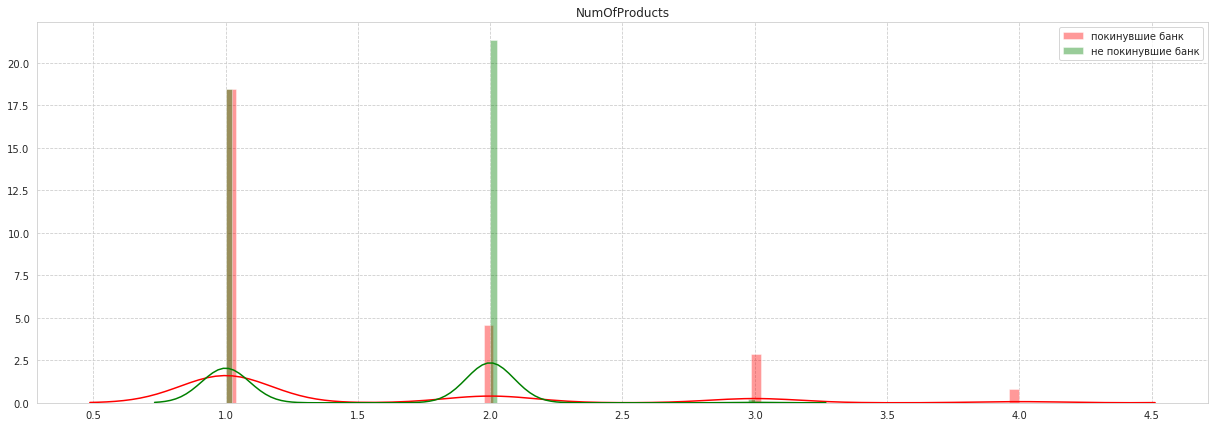

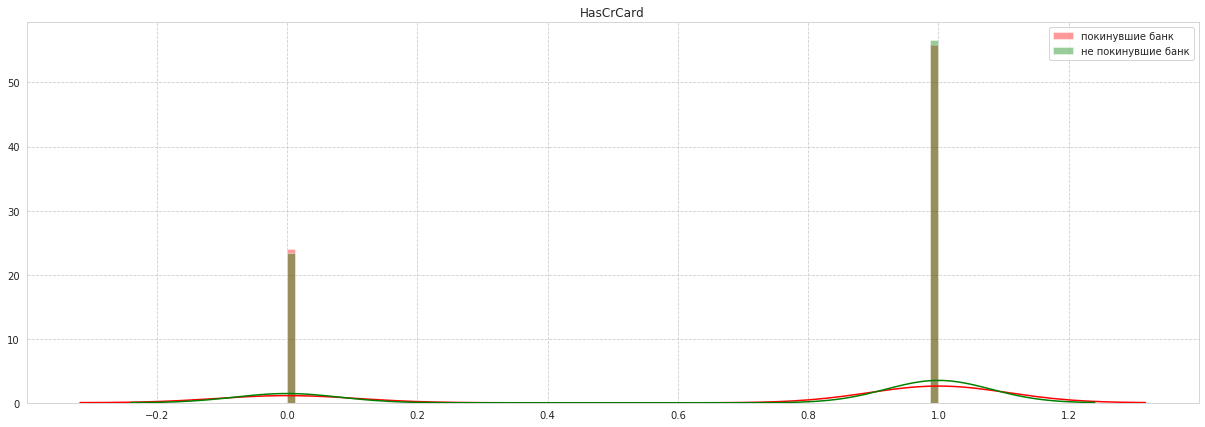

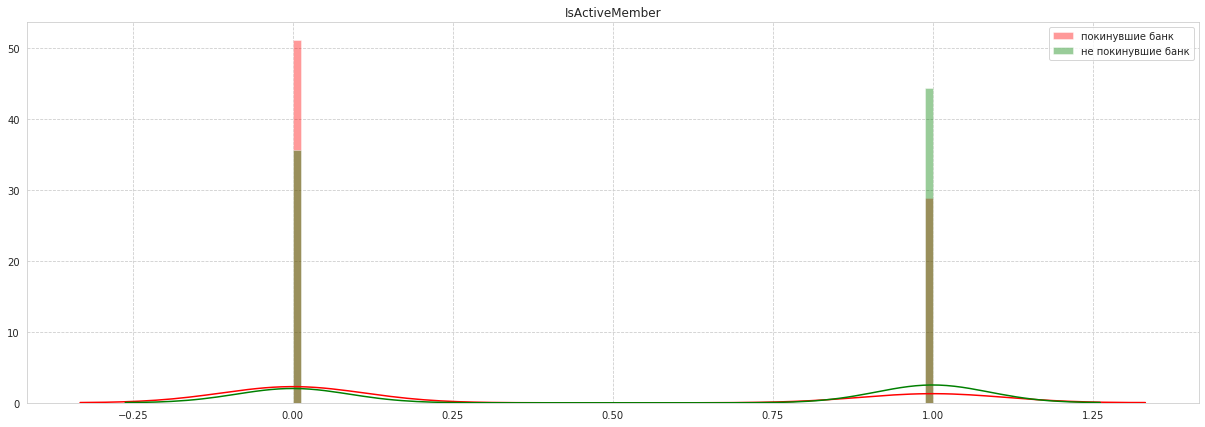

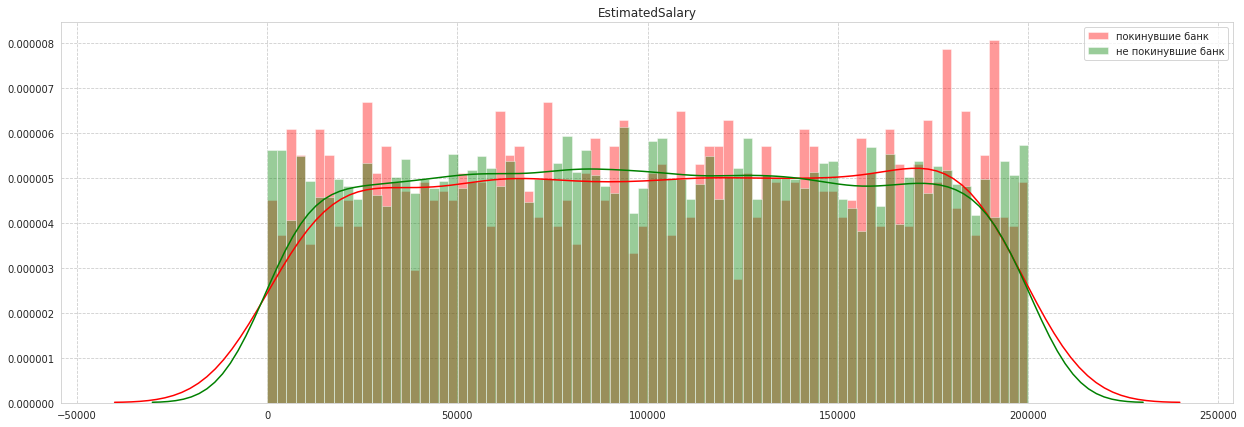

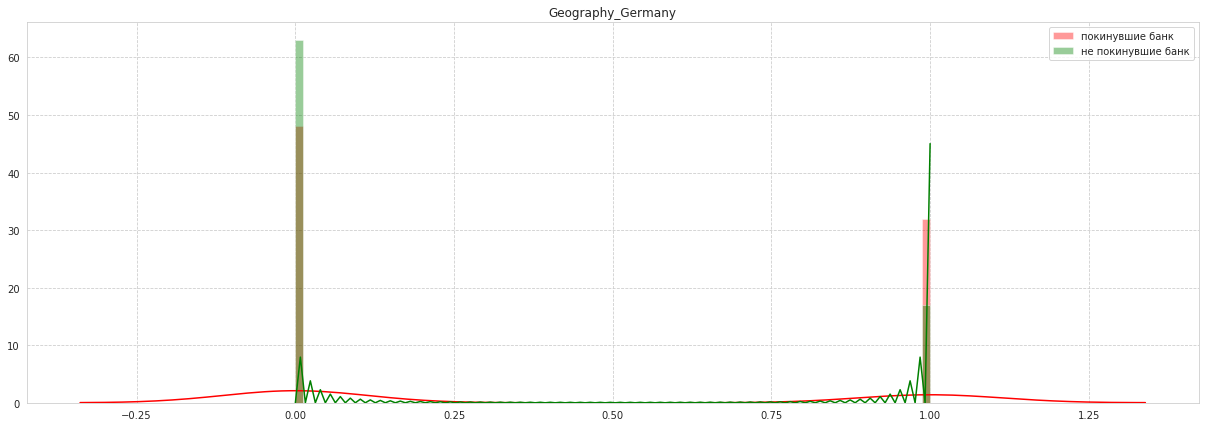

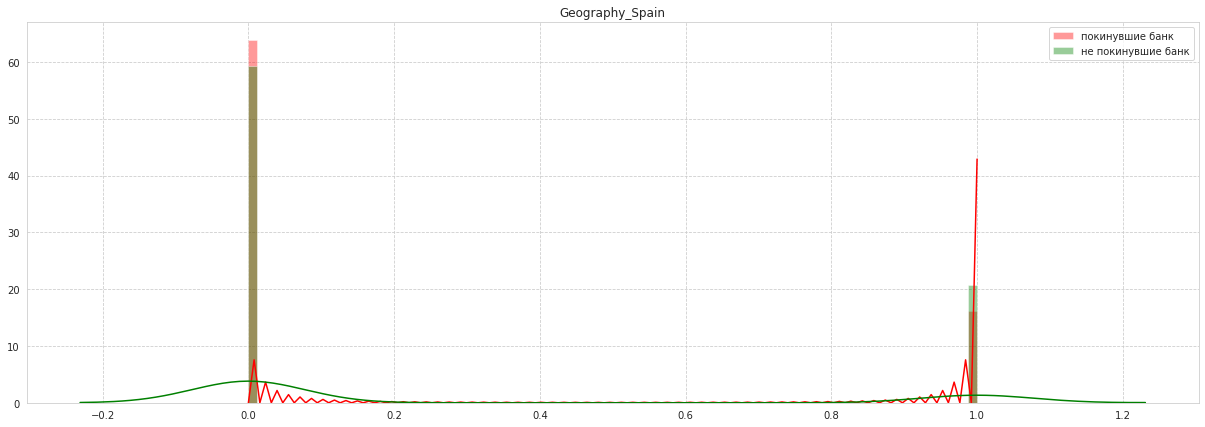

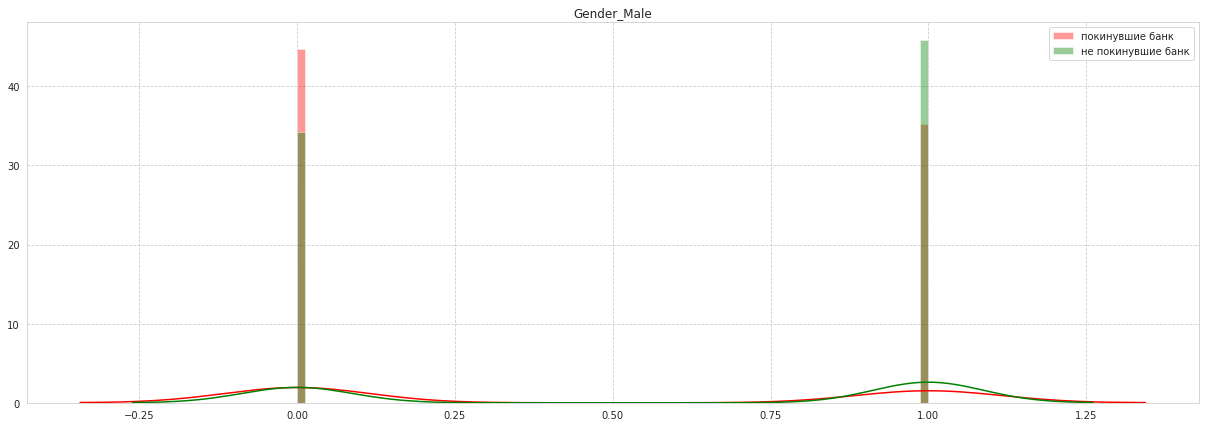

In [15]:
for column in data_churn.columns[0:12].drop('Exited'):
    fig, ax = plt.subplots(figsize=(21,7))
    ax.set_title(column)
    sns.distplot(data_churn[data_churn['Exited'] == 1][column], color='red',ax=ax, bins=80)
    sns.distplot(data_churn[data_churn['Exited'] == 0][column], color='green',ax=ax, bins=80)
    plt.xlabel('')
    plt.legend(['покинувшие банк','не покинувшие банк'])
    plt.show()

Признак HasCrCard совершенно идентично распределенны для обоих классов. Это значит, что они не как не повлияют на качаство модели (возможно, сделает хуже, но я хз), однако точно могут замедлить обучение.

После 40 лет (Age), люди активно покидают банк, и, примерно, в 45 лет респределение покинувших достигает своего пика. Также, явно видно, что люди с кредитным рейтингом (CreditScore) ниже 400, практически 100% покидают банк.

Люди, использующие больше 3-х продуктов банка (NumOfProducts) практически всегда покидают банк. Чем это вызвано, я не знаю, но факт есть факт. Ниже график, позволяющий более подробно это расмотреть.

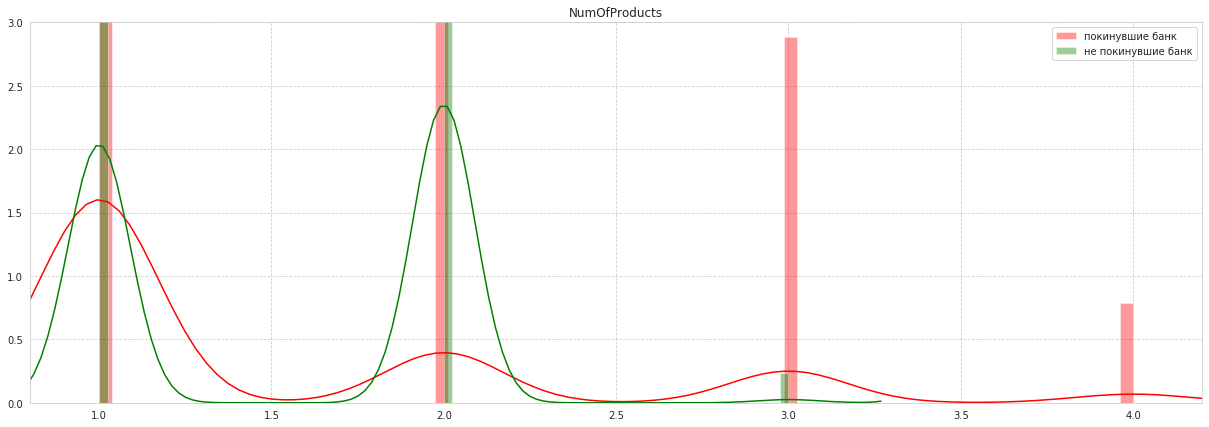

In [16]:
fig, ax = plt.subplots(figsize=(21,7))
ax.set_title('NumOfProducts')
sns.distplot(data_churn[data_churn['Exited'] == 1]['NumOfProducts'], color='red',ax=ax, bins=80)
sns.distplot(data_churn[data_churn['Exited'] == 0]['NumOfProducts'], color='green',ax=ax, bins=80)
plt.xlabel('')
plt.legend(['покинувшие банк','не покинувшие банк'])
plt.xlim(0.8,4.2)
plt.ylim(0,3)
plt.show()

Таким образом я сделал такие выводы:
 - HasCrCard можно удалить;
 - из Age, CreditScore и NumOfProducts будут выделены новые признаки для улучшения работы модели.

Все это будет сделанно на копии датасета, чтобы сравнить в дальнейшем результаты.
 

In [17]:
fixed_data_churn = data_churn.copy()

In [18]:
fixed_data_churn = fixed_data_churn.drop(['HasCrCard'], axis=1)

In [19]:
#Сделал двумя способами
#lambda
fixed_data_churn['Age_more_42'] = fixed_data_churn['Age'].map(lambda x: 1 if x > 42 else 0)
fixed_data_churn['CreditScore_less_400'] = fixed_data_churn['CreditScore'].map(lambda x: 1 if x <= 400 else 0)
#list comprehension
fixed_data_churn['NumOfProducts_more_3'] = [1 if i >= 3 else 0 for i in fixed_data_churn['NumOfProducts']]

In [20]:
fixed_data_churn

,CreditScore,Age,Tenure,Balance,NumOfProducts,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male,Age_more_42,CreditScore_less_400,NumOfProducts_more_3
0,619,42,2.0,0.00,1,1,101348.88,1,0,0,0,0,0,0
1,608,41,1.0,83807.86,1,1,112542.58,0,0,1,0,0,0,0
2,502,42,8.0,159660.80,3,0,113931.57,1,0,0,0,0,0,1
3,699,39,1.0,0.00,2,0,93826.63,0,0,0,0,0,0,0
4,850,43,2.0,125510.82,1,1,79084.10,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5.0,0.00,2,0,96270.64,0,0,0,1,0,0,0
9996,516,35,10.0,57369.61,1,1,101699.77,0,0,0,1,0,0,0
9997,709,36,7.0,0.00,1,1,42085.58,1,0,0,0,0,0,0
9998,772,42,3.0,75075.31,2,0,92888.52,1,1,0,1,0,0,0


# 2. Исследование задачи

Иссследуем задачу с дисбалансом.

In [21]:
data_churn

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5.0,0.00,2,1,0,96270.64,0,0,0,1
9996,516,35,10.0,57369.61,1,1,1,101699.77,0,0,0,1
9997,709,36,7.0,0.00,1,0,1,42085.58,1,0,0,0
9998,772,42,3.0,75075.31,2,1,0,92888.52,1,1,0,1


В начале нужно разделить на тренировочную, тестовую, и валидационную выборки и выделить в отделную таблицу целевой признак.

Я не хочу пользоваться инструментом train_test_split, так как не уверен, что он разделит на равные в процентном соотношении датасеты.

In [24]:
def normalized_train_valid_test_split(main_feature,
                                      data,
                                      random_state=None,
                                      upsampling=False,
                                      upsampling_rate=1,
                                      downsampling=False,
                                      downsampling_rate=0.6):
    """Разделение на выборки и скалирование
    
    Эта функция включает в себя две функции: Разделение 
    на выборки и скалирование. Она возвращает 3 скалированные
    выбокри с признаками и 3 выборки с целевыми признаками.
    
    """
    
    def train_valid_test_split(main_feature, 
                           data, 
                           random_state=None, 
                           upsampling=False, 
                           upsampling_rate=1, 
                           downsampling=False, 
                           downsampling_rate=0.6):
        """Разделение на выборки
    
        Эта функция разделяет данные на 3 выбоки в соотношении 3/1/1
        и передает отдельно признаки и целевые признаки. Также, вы
        можете применить upsampling и downsampling.
    
        """
    
        data_exited = data[data[main_feature] == 1]
        data_not_exited = data[data[main_feature] == 0]
    
        X_tr = data_exited.sample(frac=0.6, random_state=random_state)
    
        if upsampling:
            X_tr_upsampled = X_tr
            while upsampling_rate != 1:
                X_tr_upsampled = pd.concat([X_tr, X_tr_upsampled], axis=0)
                upsampling_rate = upsampling_rate - 1
            X_tr = X_tr_upsampled
        if downsampling:
            X_tr = pd.concat([X_tr, data_not_exited.sample(frac=downsampling_rate, random_state=random_state)], 
                         axis=0)
        else:
            X_tr = pd.concat([X_tr, data_not_exited.sample(frac=0.6, random_state=random_state)], 
                         axis=0)
        
        X_valid_test = data.loc[~data.index.isin(X_tr.index)]

        data_exited = X_valid_test[X_valid_test[main_feature] == 1]
        data_not_exited = X_valid_test[X_valid_test[main_feature] == 0]

        X_val = data_exited.sample(frac=0.5, random_state=random_state)
        X_val = pd.concat([X_val, data_not_exited.sample(frac=0.5, random_state=random_state)], 
                      axis=0)
        X_tes = X_valid_test.loc[~X_valid_test.index.isin(X_val.index)]
    
        X_tr = shuffle(X_tr, random_state=random_state)
        X_val = shuffle(X_val, random_state=random_state)
        X_tes = shuffle(X_tes, random_state=random_state)
    
        data_list, data_type_list = ([X_tr, X_val, X_tes],
                                 ['в тренировочной выборке',
                                   'в валидационной выборке', 
                                   'в тестовой выборке'])
        for data,data_type in zip(data_list, data_type_list):
            print('Процент ушедших из банка {}: {:.1%}'.format(data_type, 
                                                               data[main_feature].mean()))
    
        y_tr = X_tr[main_feature]
        y_val = X_val[main_feature]
        y_tes = X_tes[main_feature]
    
        X_tr = X_tr.drop(main_feature, 
                         axis=1)
        X_val = X_val.drop(main_feature, 
                           axis=1)
        X_tes = X_tes.drop(main_feature, 
                           axis=1)
    
        return X_tr, X_val, X_tes, y_tr, y_val, y_tes

    def scaler(feature):
        """Cкалирование
    
        Эта функция выполняет скалирование, то есть
        устанавливается среднее, равное 0, и дисперсия, равная 1.
    
        """
        
        scal=StandardScaler()
        scal.fit(feature)
        return scal.transform(feature)
    
    
    X_train, X_valid, X_test, y_train, y_valid, y_test = train_valid_test_split(main_feature,
                                                                                data,
                                                                                random_state=random_state,
                                                                                upsampling=upsampling,
                                                                                upsampling_rate=upsampling_rate,
                                                                                downsampling=downsampling,
                                                                                downsampling_rate=downsampling_rate)
    X_train = scaler(X_train)
    X_valid = scaler(X_valid) 
    X_test = scaler(X_test)
    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [25]:
X_train, X_valid, X_test, y_train, y_valid, y_test = normalized_train_valid_test_split(main_feature='Exited', data=data_churn, random_state=123)

Процент ушедших из банка в тренировочной выборке: 20.4%
Процент ушедших из банка в валидационной выборке: 20.4%
Процент ушедших из банка в тестовой выборке: 20.3%


In [26]:
print('Количество тренировочных признаков:',len(X_train))
print('Количество тренировочных целевых признаков:',len(y_train))
print('')
print('Количество валидационных признаков:',len(X_valid))
print('Количество валидационных целевых признаков:',len(y_valid))
print('')
print('Количество тестовых признаков:',len(X_test))
print('Количество тестовых целевых признаков:',len(y_test))

Количество тренировочных признаков: 6000
Количество тренировочных целевых признаков: 6000

Количество валидационных признаков: 2000
Количество валидационных целевых признаков: 2000

Количество тестовых признаков: 2000
Количество тестовых целевых признаков: 2000


Тоже самое для fixed_data_churn.

In [27]:
fix_X_train, fix_X_valid, fix_X_test, fix_y_train, fix_y_valid, fix_y_test = normalized_train_valid_test_split('Exited', fixed_data_churn, random_state=124)

Процент ушедших из банка в тренировочной выборке: 20.4%
Процент ушедших из банка в валидационной выборке: 20.4%
Процент ушедших из банка в тестовой выборке: 20.3%


In [28]:
print('Количество тренировочных признаков:',len(fix_X_train))
print('Количество тренировочных целевых признаков:',len(fix_y_train))
print('')
print('Количество валидационных признаков:',len(fix_X_valid))
print('Количество валидационных целевых признаков:',len(fix_y_valid))
print('')
print('Количество тестовых признаков:',len(fix_X_test))
print('Количество тестовых целевых признаков:',len(fix_y_test))

Количество тренировочных признаков: 6000
Количество тренировочных целевых признаков: 6000

Количество валидационных признаков: 2000
Количество валидационных целевых признаков: 2000

Количество тестовых признаков: 2000
Количество тестовых целевых признаков: 2000


## Обучение

<i> значения в выводе и результат работы могут отличаться.</i>

In [29]:
# Функция построения марицы ошибок.
# я ее где-то "свистнул", еще когда 
# научно-исследовательскую писал в 
# институте, уже и не вспомню.

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Матрица путаницы',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        1

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Действительная оценка')
    plt.xlabel('Предсказанная оценка')
    plt.show()

In [30]:
def plot_Precision_Recall_curve(model, X_valid, y_valid):
    probabilities_valid = model.predict_proba(X_valid)
    precision, recall, thresholds = precision_recall_curve(y_valid, probabilities_valid[:, 1])

    plt.figure(figsize=(21, 7))
    plt.step(recall, precision, where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Кривая Precision-Recall')
    plt.show()

In [31]:
def plot_ROC_curve(model, X_valid, y_valid):
    probabilities_valid = model.predict_proba(X_valid)
    probabilities_one_valid = probabilities_valid[:, 1]

    fpr, tpr, thresholds = roc_curve(y_valid, probabilities_one_valid)

    plt.figure(figsize=(21, 7))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-кривая")
    plt.show()
    return probabilities_one_valid

### Логистическая регрессия

In [32]:
def logistic_regression(X_train,
                        y_train,
                        X_valid,  
                        y_valid,
                        c_range=[1e-10, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e1, 1e2, 1e3, 1e4, 1e5], weight=None):
    f1 = 0
    final_range = 0
    for c in notebook.tqdm(c_range):
        model = LogisticRegression(random_state=44, solver='liblinear', C=c, class_weight=weight)
        model.fit(X_train, y_train)
        predicted_valid = model.predict(X_valid)
        if f1 < f1_score(y_valid, predicted_valid):
            f1 = f1_score(y_valid, predicted_valid)
            final_range=c
            
    model = LogisticRegression(random_state=44, solver='liblinear', C=final_range)
    model.fit(X_train, y_train)
    predicted_valid = model.predict(X_valid)
    
    print('Допуск:', final_range)
    print('Accuracy: ', accuracy_score(y_valid, predicted_valid))
    print('Полнота: ', recall_score(y_valid, predicted_valid))
    print('Точность: ', precision_score(y_valid, predicted_valid))
    print('F1: ', f1_score(y_valid, predicted_valid))
    
    return model, predicted_valid

#### Обычная выборка

In [33]:
model, predicted_valid = logistic_regression(X_train, y_train, X_valid, y_valid)


Допуск: 0.1
Accuracy:  0.81
Полнота:  0.2181372549019608
Точность:  0.5933333333333334
F1:  0.31899641577060933


F1:  0.31899641577060933


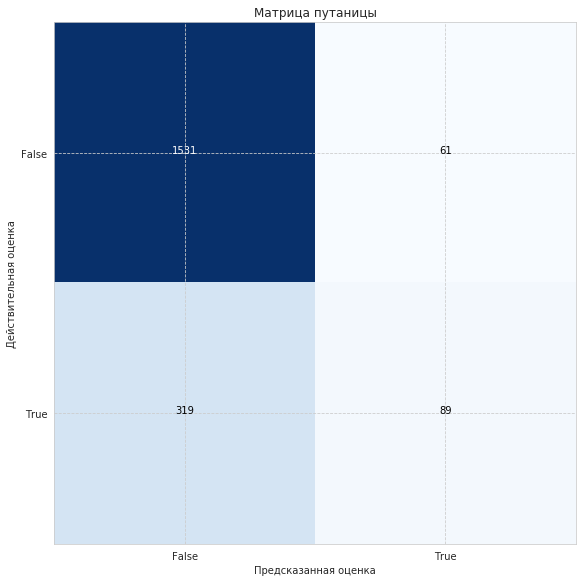

In [34]:
cnf_matrix = confusion_matrix(y_valid, predicted_valid)

print('F1: ', f1_score(y_valid, predicted_valid))
class_names = ["False","True"]
plt.figure(figsize=(16,8))
plot_confusion_matrix(cnf_matrix,
                      classes=class_names,
                      normalize=False)

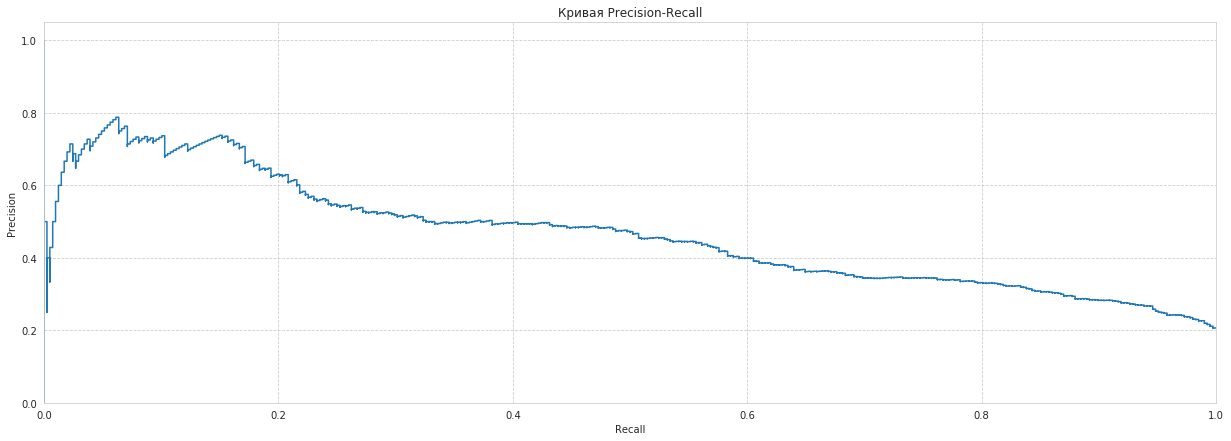

In [35]:
plot_Precision_Recall_curve(model, X_valid, y_valid)

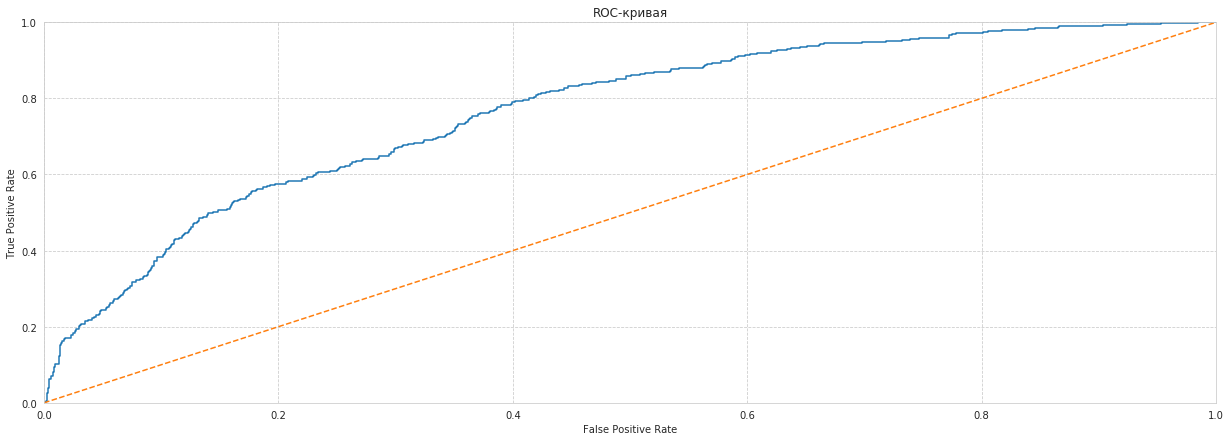

In [36]:
probabilities_one_valid = plot_ROC_curve(model, X_valid, y_valid)

In [37]:
print('AUC-ROC: ', roc_auc_score(y_valid, probabilities_one_valid))
print('F1: ', f1_score(y_valid, predicted_valid))

AUC-ROC:  0.76573892748054
F1:  0.31899641577060933


#### Исправленная выборка

In [38]:
model, predicted_valid = logistic_regression(fix_X_train, fix_y_train, fix_X_valid, fix_y_valid)


Допуск: 0.0001
Accuracy:  0.823
Полнота:  0.49264705882352944
Точность:  0.5775862068965517
F1:  0.5317460317460317


F1:  0.5317460317460317


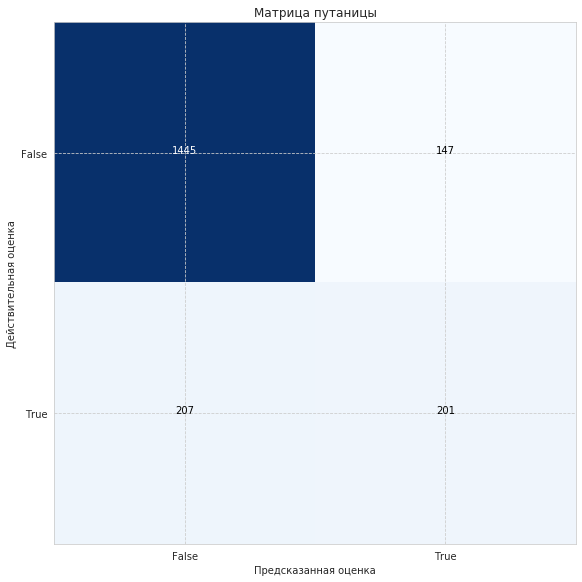

In [39]:
cnf_matrix = confusion_matrix(fix_y_valid, predicted_valid)

print('F1: ', f1_score(fix_y_valid, predicted_valid))
class_names = ["False","True"]
plt.figure(figsize=(16,8))
plot_confusion_matrix(cnf_matrix
                          , classes=class_names, normalize=False)

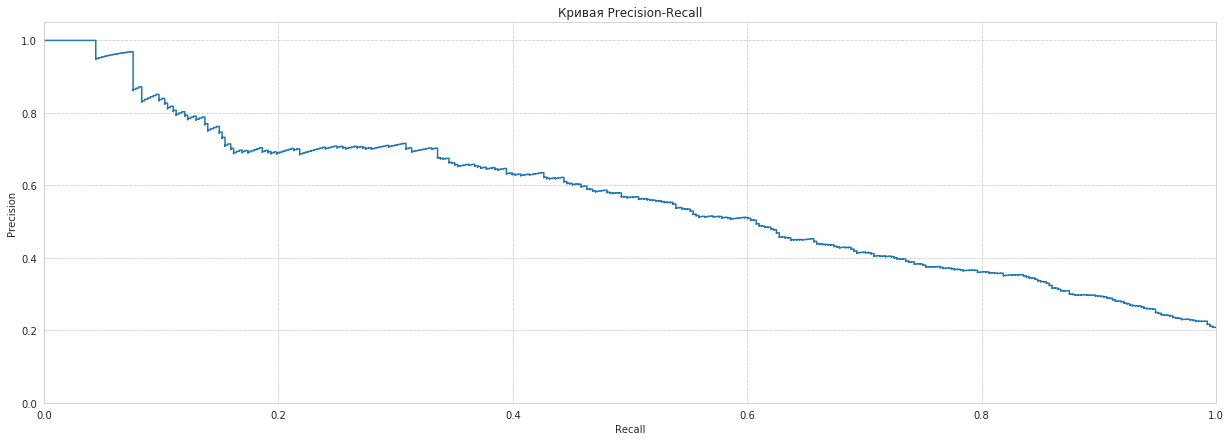

In [40]:
plot_Precision_Recall_curve(model, fix_X_valid, fix_y_valid)

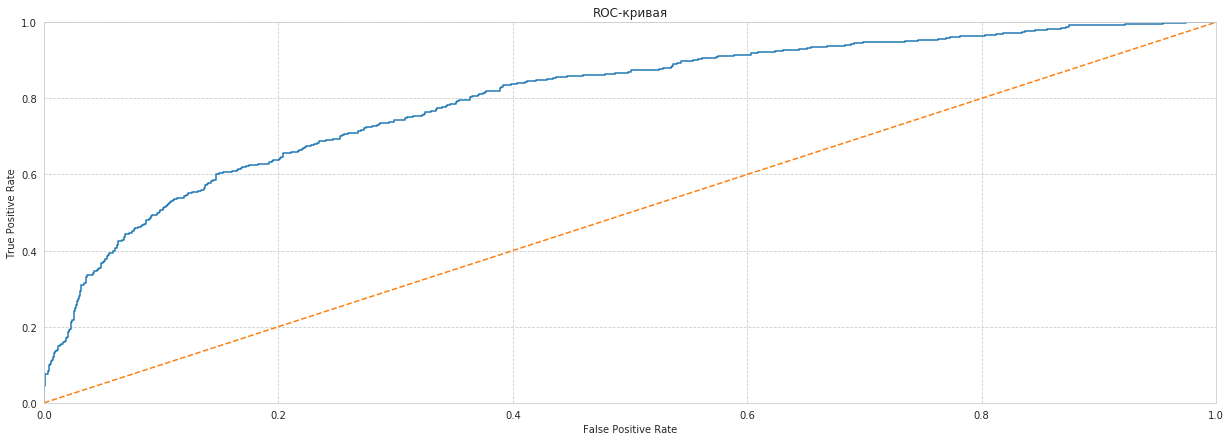

In [41]:
probabilities_one_valid = plot_ROC_curve(model, fix_X_valid, fix_y_valid)

In [42]:
print('AUC-ROC: ', roc_auc_score(fix_y_valid, probabilities_one_valid))
print('F1: ', f1_score(fix_y_valid, predicted_valid))

AUC-ROC:  0.8018616366144449
F1:  0.5317460317460317


#### Вывод по логистической регрессии

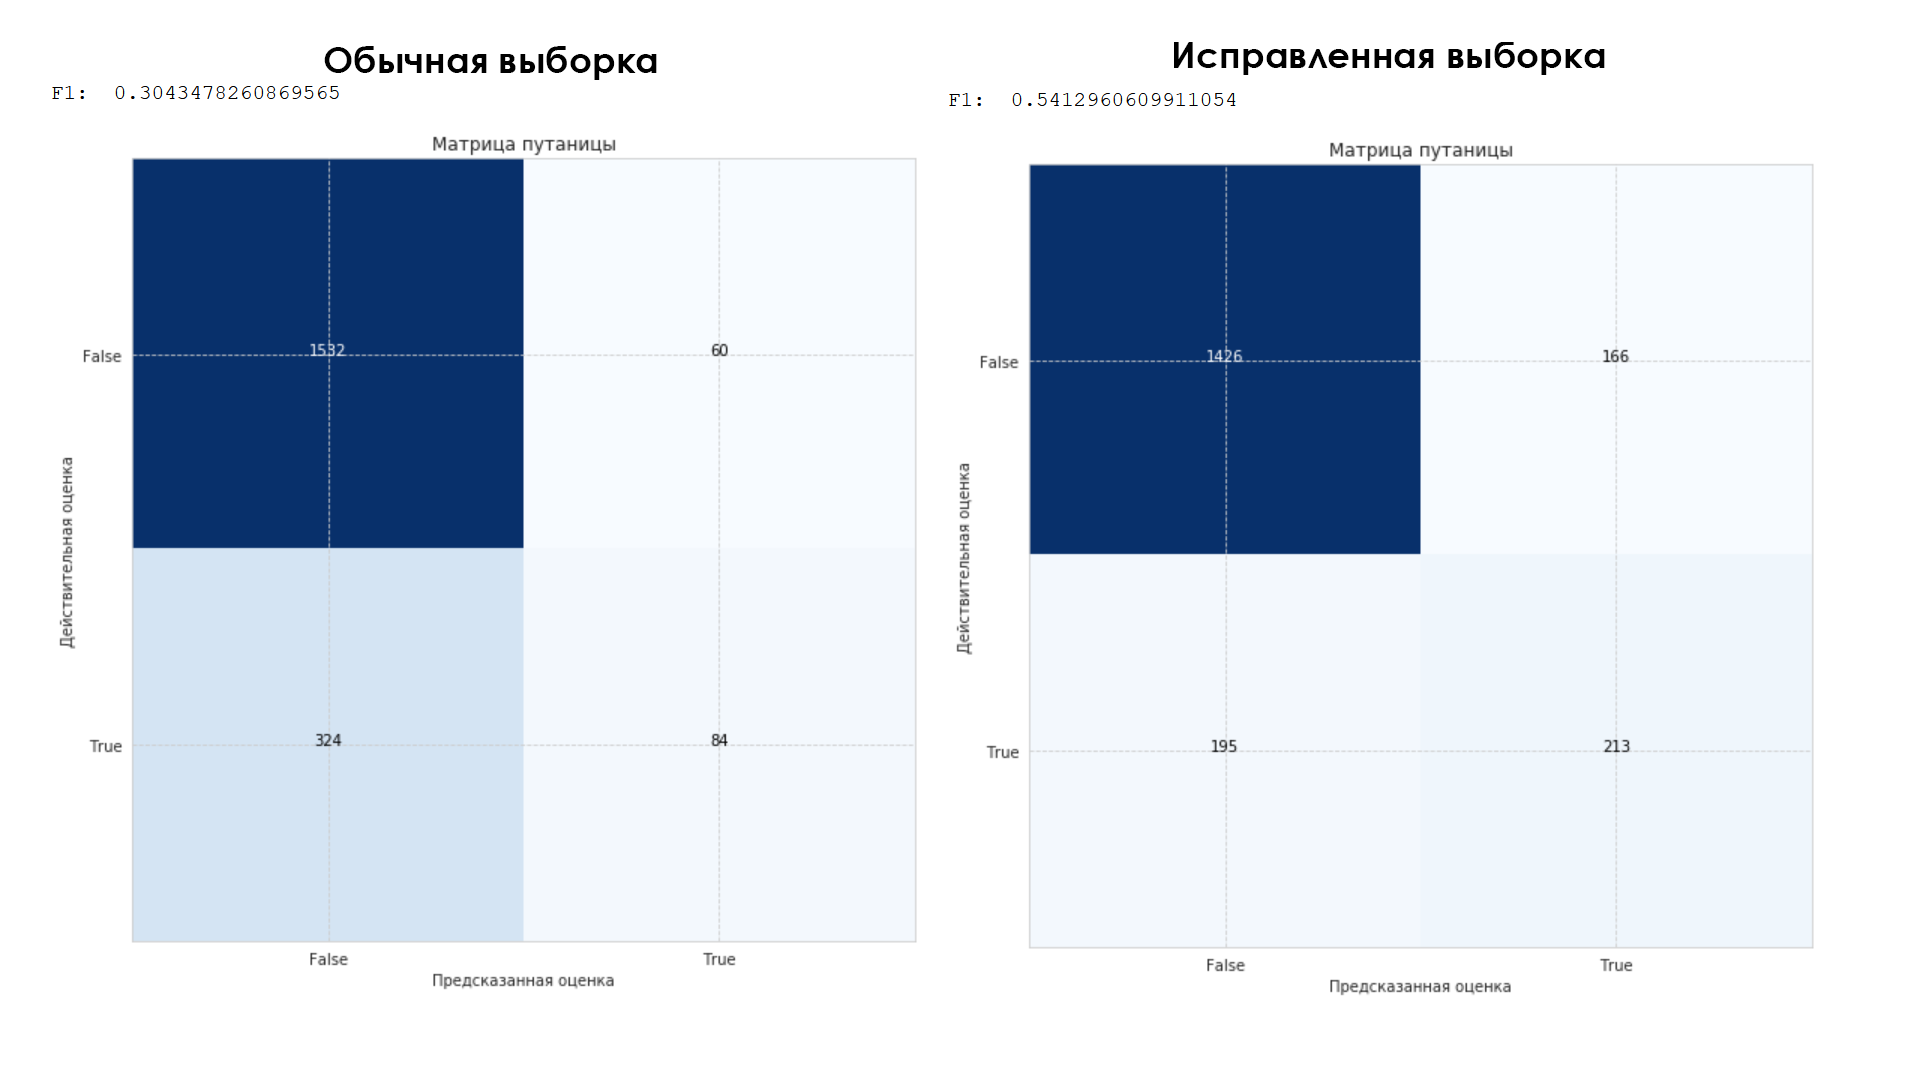

Как видно из сравнения матриц, модель, обученная по исправленной выборке, значительно лучше определяет истинно-положительные результаты (213/408 против 84/408). Ценой тому является незначительно увеличеное количество ложно-положительных результатов.

Также метрика F1 у модели, обученная по исправленной выборке, значительно выше,чем у обычной выборки (0.541 против 0.304).

В целом, метрики логистической регрессии довольно низкие и стоит поискать другой алгоритм обучения.

### Случайный лес

In [43]:
def random_forest(X_train, y_train, X_valid, y_valid, estim_range = range(10,311,20), depth_range = range(7,24,1)):
    
    def estim_search(X_train, y_train, X_valid, y_valid, estim_range):
        f1 = 0
        final_estim=0
        print('Поиск оптимального числа деревьев...')
        for estim in notebook.tqdm(estim_range):
            model = RandomForestClassifier(random_state=44, n_estimators=estim, n_jobs=-1)
            model.fit(X_train, y_train)
            predicted_valid = model.predict(X_valid)
            if f1 < f1_score(y_valid, predicted_valid):
                f1 = f1_score(y_valid, predicted_valid)
                final_estim=estim
        print('Лучшая модель с ', final_estim , 'деревьев')
        return final_estim
                   
    def depth_search(X_train, y_train, X_valid, y_valid, depth_range, final_estim):
        f1 = 0
        final_depth=0
        print('Поиск оптимальной глубины...')
        for depth in notebook.tqdm(depth_range):
            model = RandomForestClassifier(random_state=44, n_estimators=final_estim, max_depth=depth, n_jobs=-1)
            model.fit(X_train, y_train)
            predicted_valid = model.predict(X_valid)
            if f1 < f1_score(y_valid, predicted_valid):
                f1 = f1_score(y_valid, predicted_valid)
                final_depth=depth
        print('Лучшая модель с глубиной:', final_depth)
        return final_depth
    
    final_estim = estim_search(X_train, y_train, X_valid, y_valid, estim_range)
    final_depth = depth_search(X_train, y_train, X_valid, y_valid, depth_range, final_estim)
    
    model = RandomForestClassifier(random_state=44, n_estimators=final_estim, max_depth=final_depth, n_jobs=-1)
    model.fit(X_train, y_train)
    predicted_valid = model.predict(X_valid)
    
    print('')
    print('Количество деревьев: ', final_estim,', глубина', final_depth)
    print('Accuracy ', accuracy_score(y_valid, predicted_valid))
    print('Полнота: ', recall_score(y_valid, predicted_valid))
    print('Точность: ', precision_score(y_valid, predicted_valid))
    print('F1: ', f1_score(y_valid, predicted_valid))
    
    return model, predicted_valid

#### Обычная выборка

In [44]:
model, predicted_valid = random_forest(X_train, y_train, X_valid, y_valid)

Поиск оптимального числа деревьев...



Лучшая модель с  50 деревьев
Поиск оптимальной глубины...



Лучшая модель с глубиной: 20

Количество деревьев:  50 , глубина 20
Accuracy  0.8615
Полнота:  0.4730392156862745
Точность:  0.7568627450980392
F1:  0.5822021116138762


F1:  0.5822021116138762


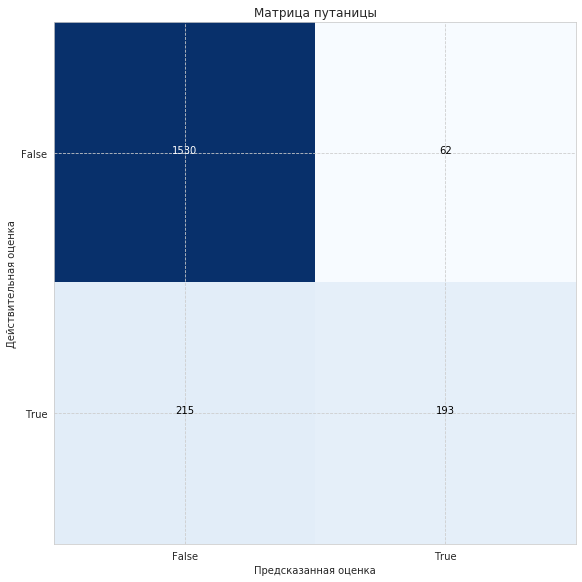

In [45]:
cnf_matrix = confusion_matrix(y_valid, predicted_valid)

print('F1: ', f1_score(y_valid, predicted_valid))
class_names = ["False","True"]
plt.figure(figsize=(16,8))
plot_confusion_matrix(cnf_matrix
                          , classes=class_names, normalize=False)

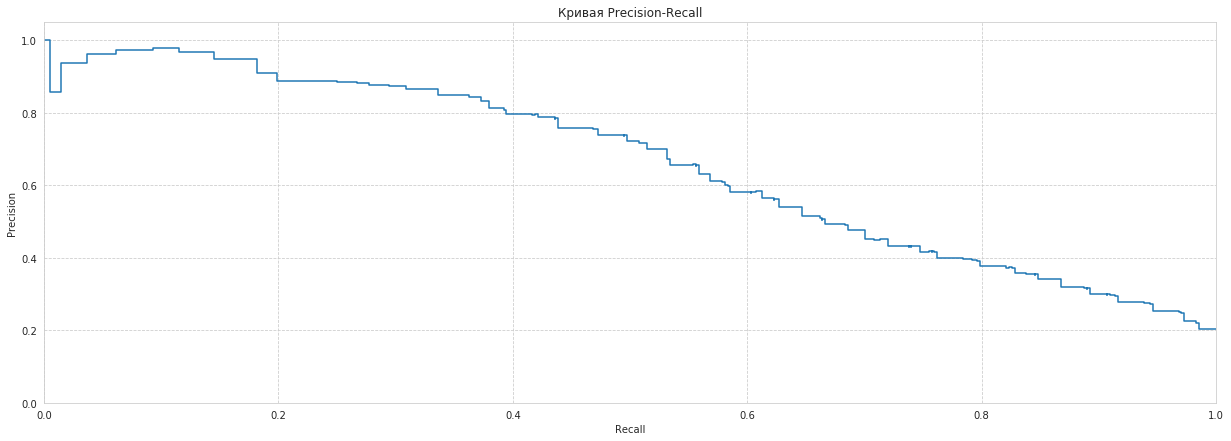

In [46]:
plot_Precision_Recall_curve(model, X_valid, y_valid)

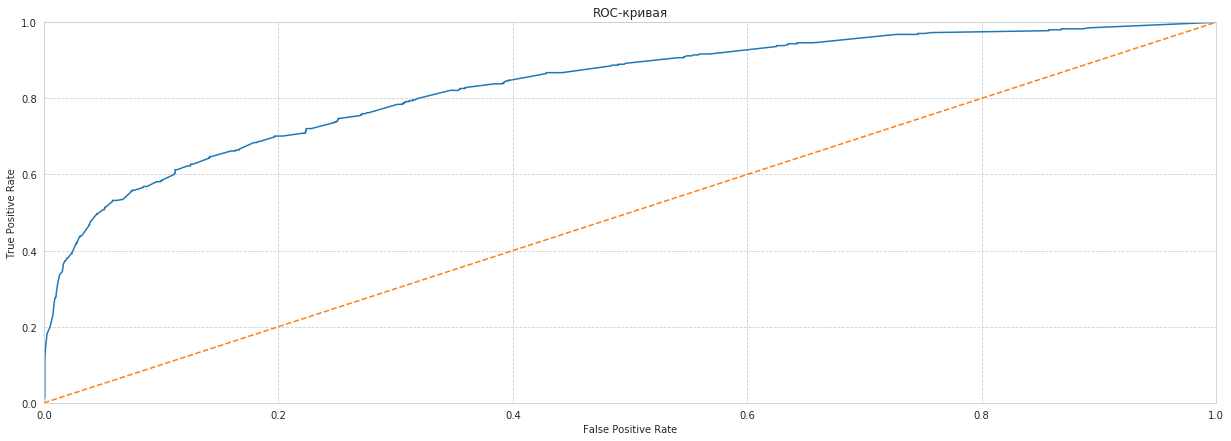

In [47]:
probabilities_one_valid = plot_ROC_curve(model, X_valid, y_valid)

In [48]:
print('AUC-ROC: ', roc_auc_score(y_valid, probabilities_one_valid))
print('F1: ', f1_score(y_valid, predicted_valid))

AUC-ROC:  0.8342593790028574
F1:  0.5822021116138762


#### Исправленная выборка

In [49]:
model, predicted_valid = random_forest(fix_X_train, fix_y_train, fix_X_valid, fix_y_valid)

Поиск оптимального числа деревьев...



Лучшая модель с  110 деревьев
Поиск оптимальной глубины...



Лучшая модель с глубиной: 18

Количество деревьев:  110 , глубина 18
Accuracy  0.8625
Полнота:  0.4852941176470588
Точность:  0.752851711026616
F1:  0.5901639344262295


F1:  0.5901639344262295


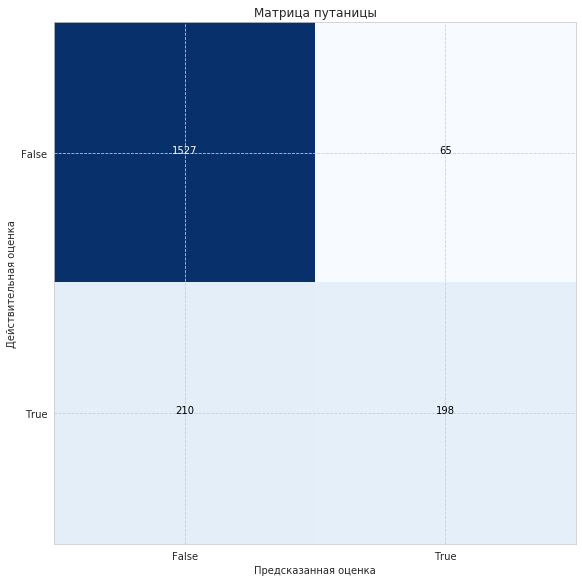

In [50]:
cnf_matrix = confusion_matrix(fix_y_valid, predicted_valid)

print('F1: ', f1_score(fix_y_valid, predicted_valid))
class_names = ["False","True"]
plt.figure(figsize=(16,8))
plot_confusion_matrix(cnf_matrix
                          , classes=class_names, normalize=False)

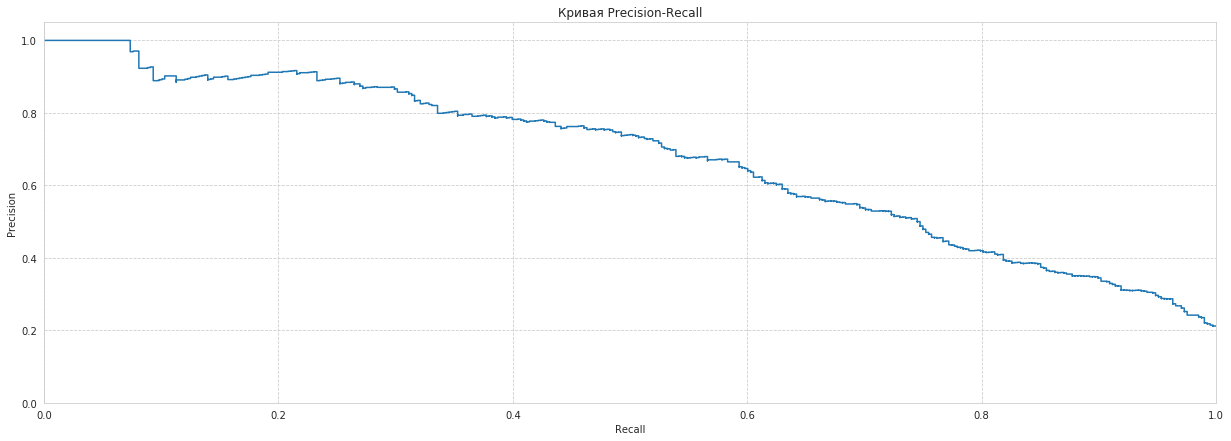

In [51]:
plot_Precision_Recall_curve(model, fix_X_valid, fix_y_valid)

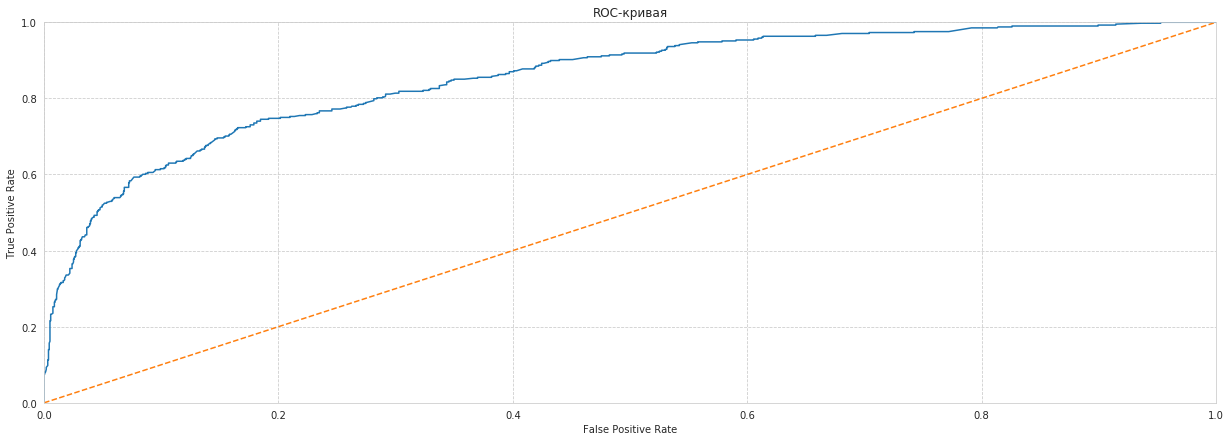

In [52]:
probabilities_one_valid = plot_ROC_curve(model, fix_X_valid, fix_y_valid)

In [53]:
print('AUC-ROC: ', roc_auc_score(fix_y_valid, probabilities_one_valid))
print('F1: ', f1_score(fix_y_valid, predicted_valid))

AUC-ROC:  0.8538287331264165
F1:  0.5901639344262295


#### Вывод по случайному лесу

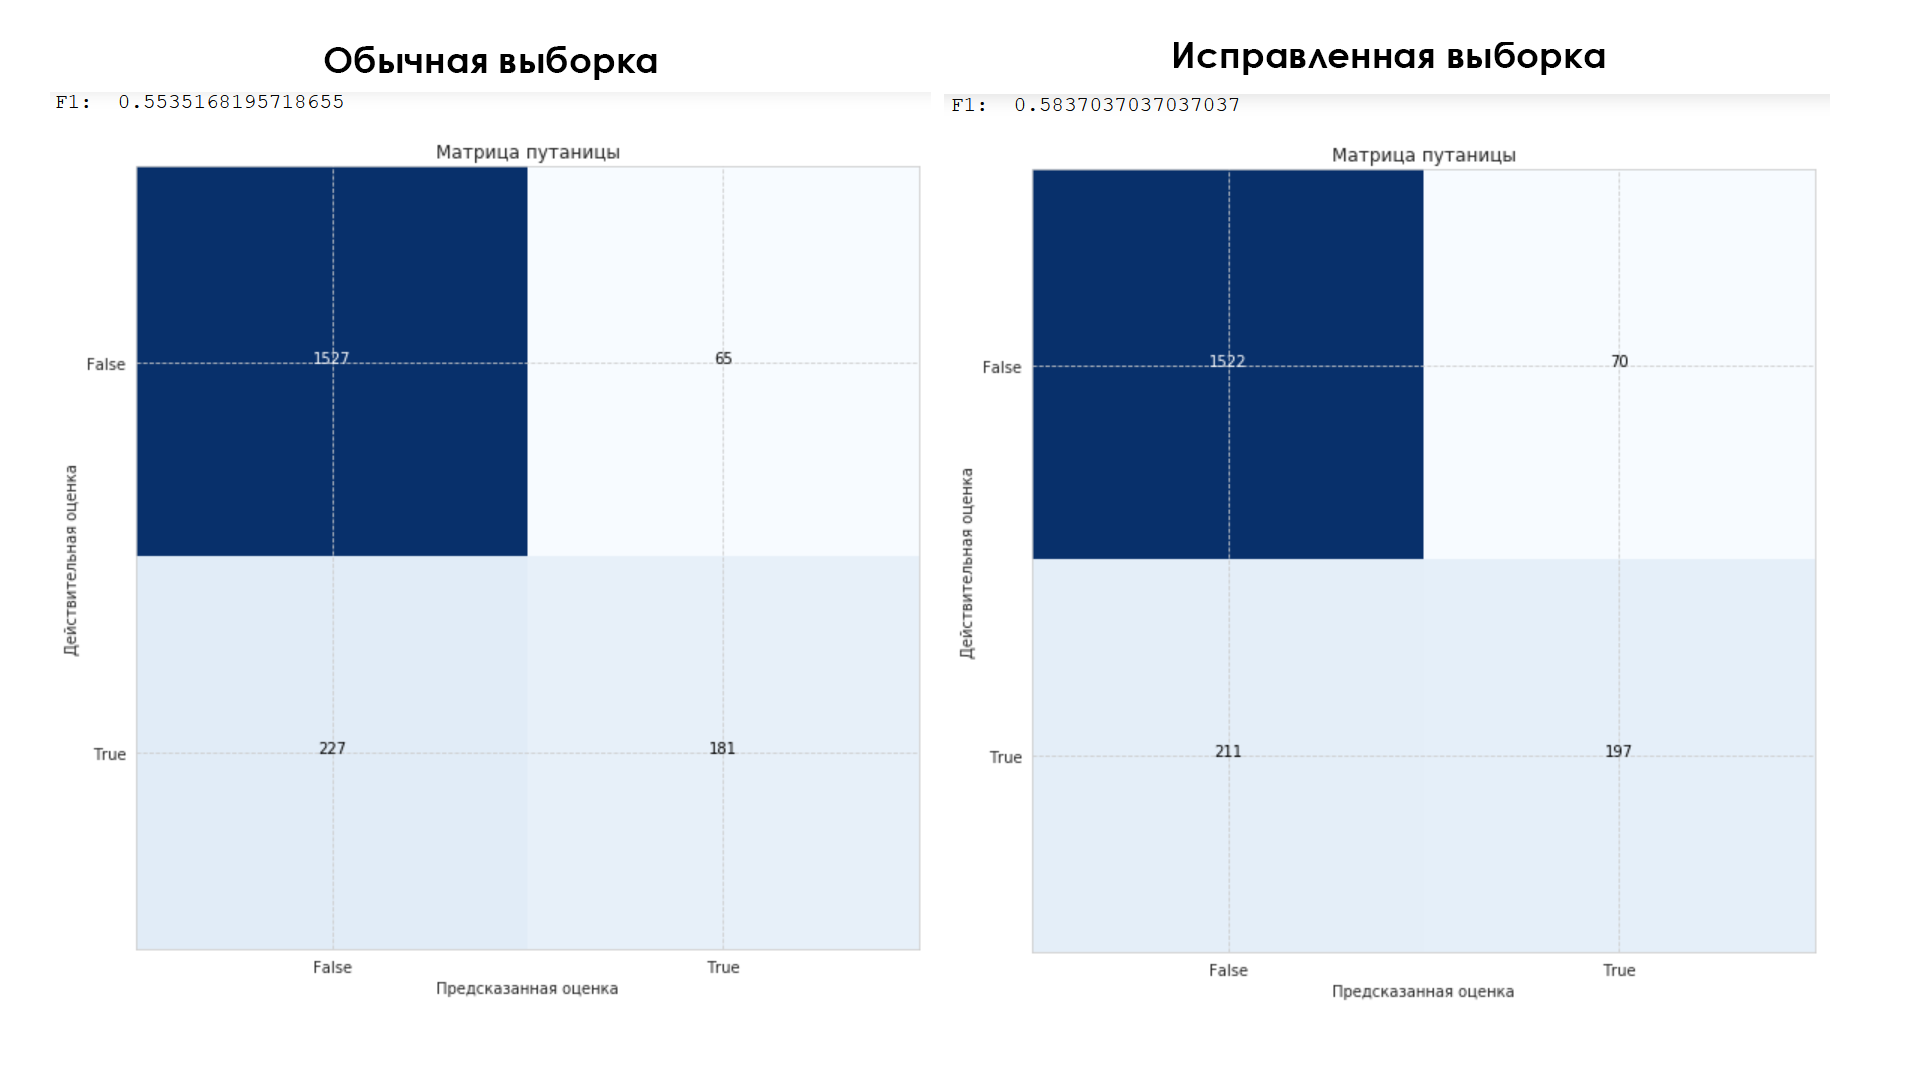

Здесь исправленная выборка опять показала себя лучше, но уже менее значительно.

Обучим модель методом градиентного спуска.

### Градиентный спуск

In [54]:
def gradient_boosting(X_train, y_train, X_valid, y_valid, estim_range=range(5,250,5)):
    f1 = 0
    fin_estim=0
    print('Поиск оптимального количества итераций...')
    for estim in notebook.tqdm(estim_range):
        model = GradientBoostingClassifier(random_state=44, n_estimators=estim)
        model.fit(X_train, y_train)
        predicted_valid = model.predict(X_valid)
        if f1 < f1_score(y_valid, predicted_valid):
            f1 = f1_score(y_valid, predicted_valid)
            fin_estim=estim
    print('Лучшая модель с ', fin_estim, 'итераций')
    
    model = GradientBoostingClassifier(random_state=44, n_estimators=fin_estim)
    model.fit(X_train, y_train)
    predicted_valid = model.predict(X_valid)
    print('')
    print('Количество итераций: ', fin_estim)
    print('Accuracy ', accuracy_score(y_valid, predicted_valid))
    print('Полнота: ', recall_score(y_valid, predicted_valid))
    print('Точность: ', precision_score(y_valid, predicted_valid))
    print('F1: ', f1_score(y_valid, predicted_valid))
    
    return model, predicted_valid

#### Обычная выборка

In [55]:
model, predicted_valid = gradient_boosting(X_train, y_train, X_valid, y_valid)

Поиск оптимального количества итераций...



Лучшая модель с  195 итераций

Количество итераций:  195
Accuracy  0.8585
Полнота:  0.49264705882352944
Точность:  0.7256317689530686
F1:  0.5868613138686131


F1:  0.5868613138686131


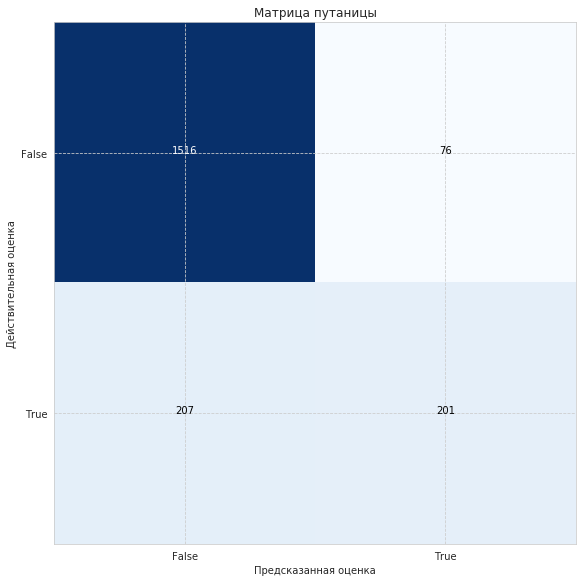

In [56]:
cnf_matrix = confusion_matrix(y_valid, predicted_valid)

print('F1: ', f1_score(y_valid, predicted_valid))
class_names = ["False","True"]
plt.figure(figsize=(16,8))
plot_confusion_matrix(cnf_matrix
                          , classes=class_names, normalize=False)

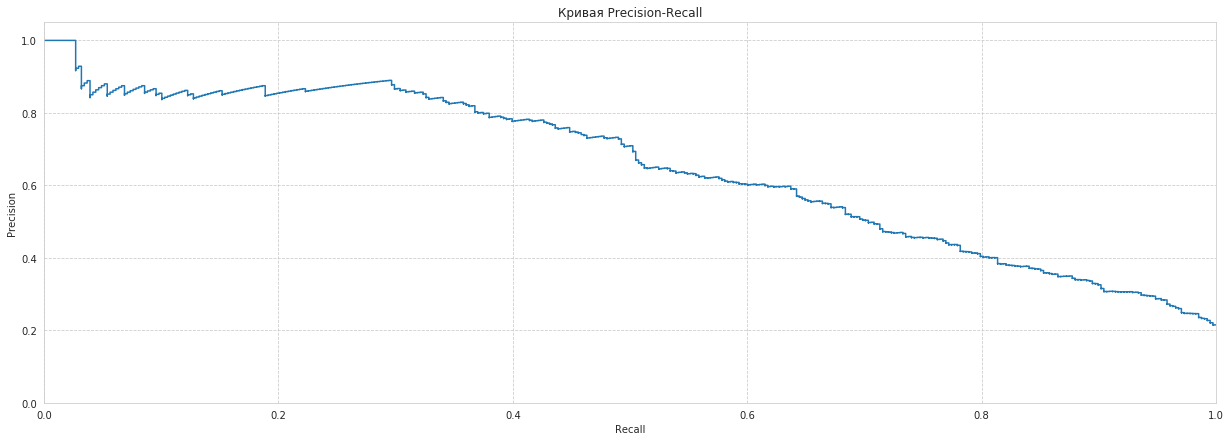

In [57]:
plot_Precision_Recall_curve(model, X_valid, y_valid)

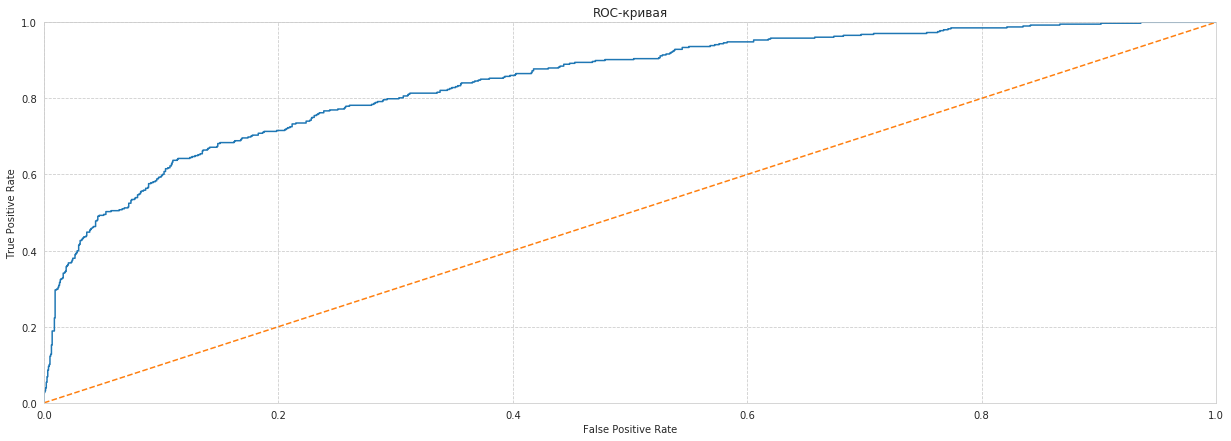

In [58]:
probabilities_one_valid = plot_ROC_curve(model, X_valid, y_valid)

In [59]:
print('AUC-ROC: ', roc_auc_score(y_valid, probabilities_one_valid))
print('F1: ', f1_score(y_valid, predicted_valid))

AUC-ROC:  0.8450162885505961
F1:  0.5868613138686131


#### Исправленная выборка

In [60]:
model, predicted_valid = gradient_boosting(fix_X_train, fix_y_train, fix_X_valid, fix_y_valid)

Поиск оптимального количества итераций...



Лучшая модель с  235 итераций

Количество итераций:  235
Accuracy  0.867
Полнота:  0.5024509803921569
Точность:  0.7649253731343284
F1:  0.606508875739645


F1:  0.606508875739645


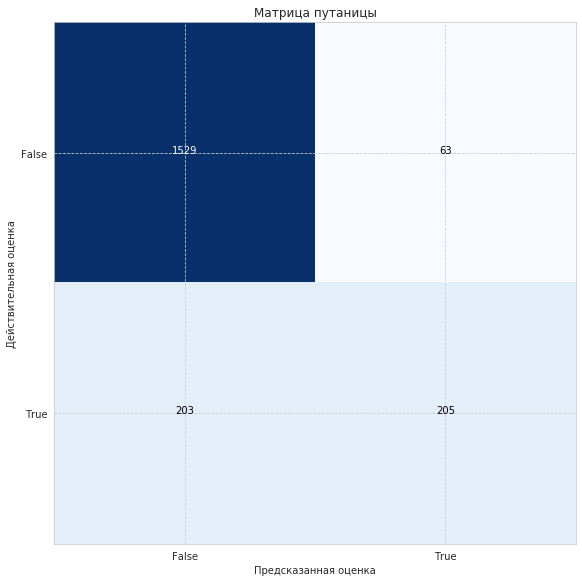

In [61]:
cnf_matrix = confusion_matrix(fix_y_valid, predicted_valid)

print('F1: ', f1_score(fix_y_valid, predicted_valid))
class_names = ["False","True"]
plt.figure(figsize=(16,8))
plot_confusion_matrix(cnf_matrix
                          , classes=class_names, normalize=False)

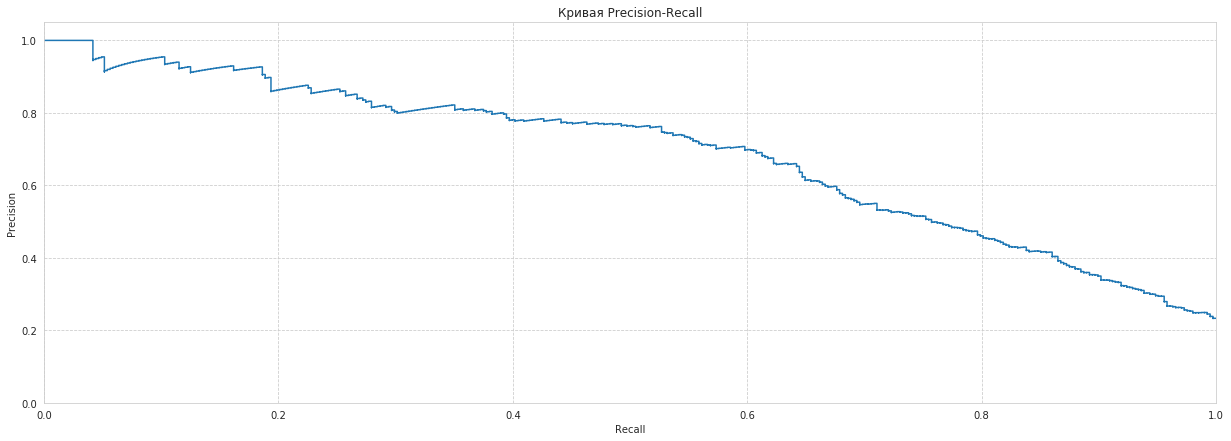

In [62]:
plot_Precision_Recall_curve(model, fix_X_valid, fix_y_valid)

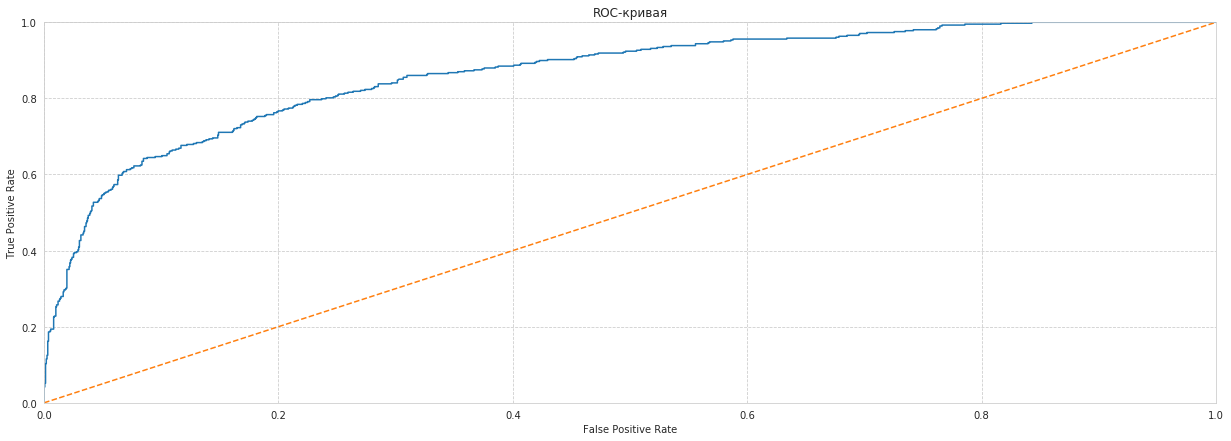

In [63]:
probabilities_one_valid = plot_ROC_curve(model, fix_X_valid, fix_y_valid)

In [64]:
print('AUC-ROC: ', roc_auc_score(fix_y_valid, probabilities_one_valid))
print('F1: ', f1_score(fix_y_valid, predicted_valid))

AUC-ROC:  0.8656787306631196
F1:  0.606508875739645


#### Вывод по градинтному спуску

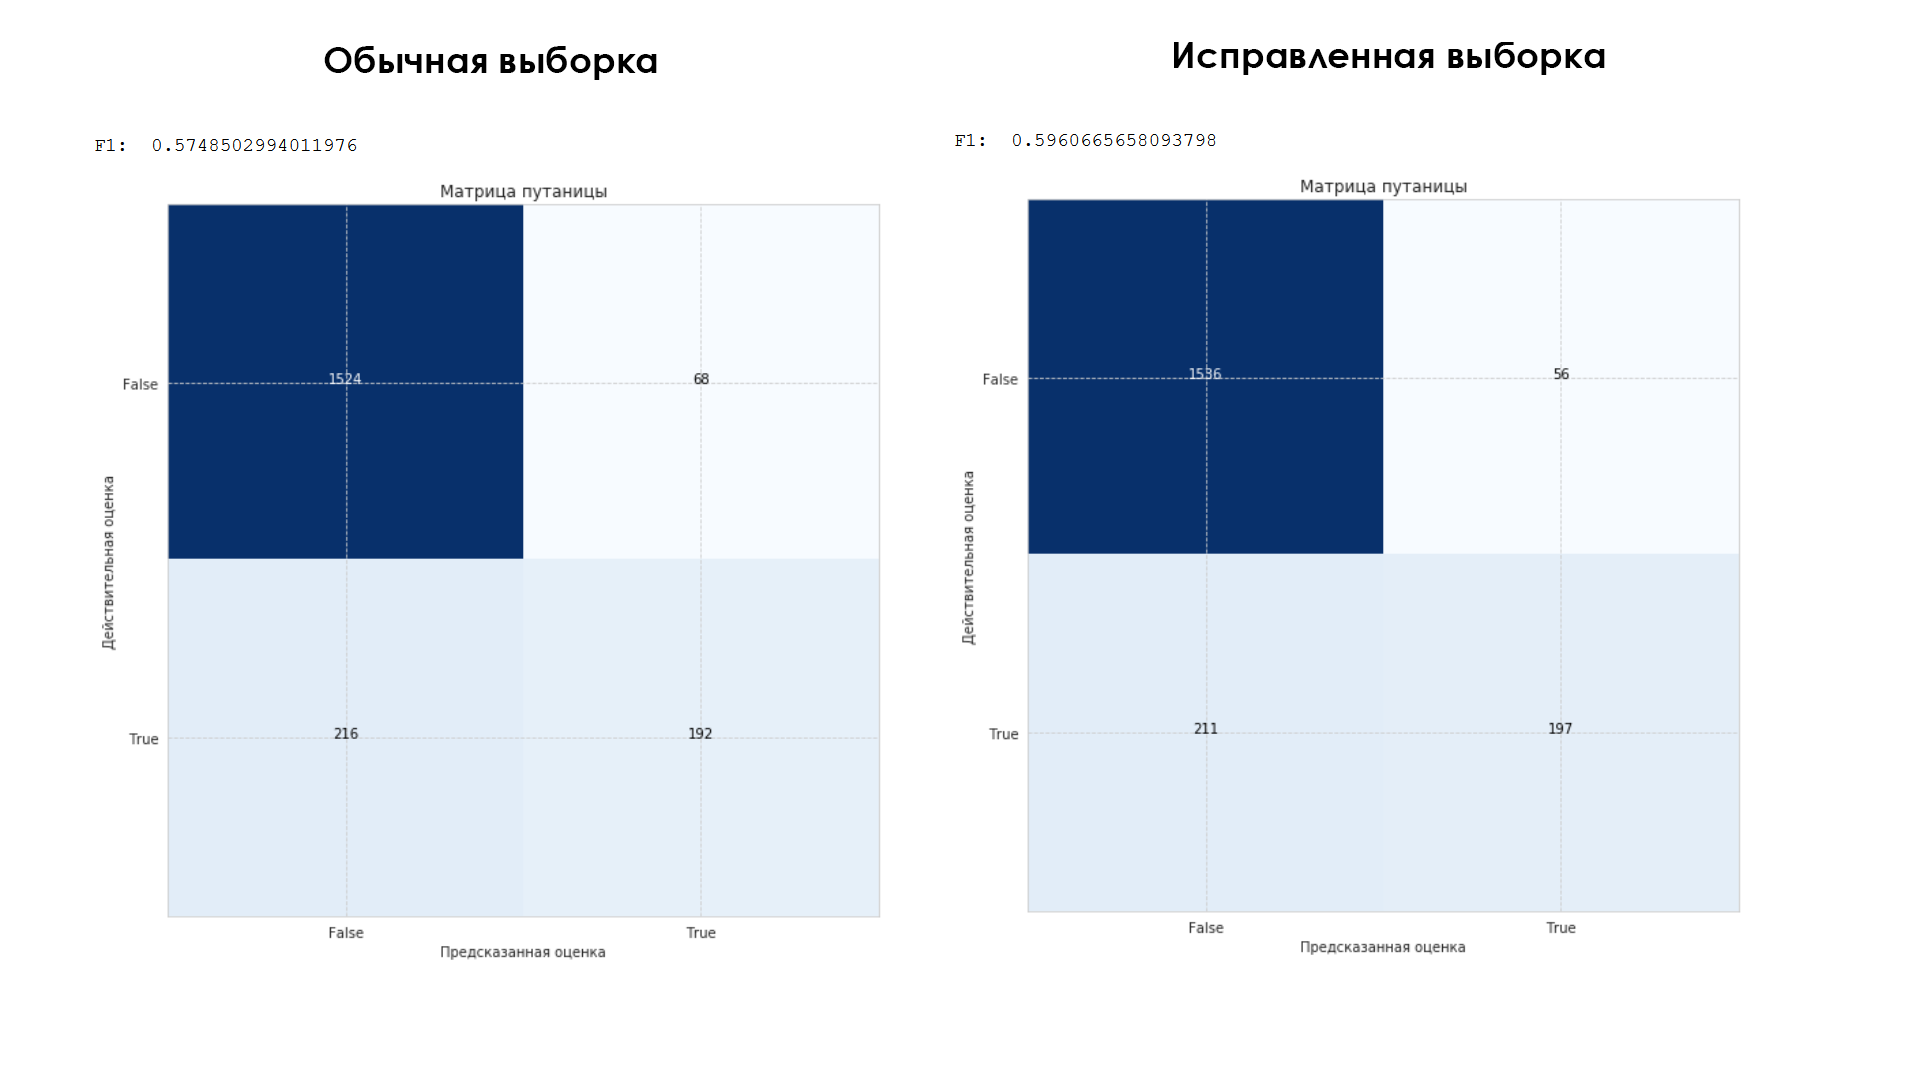

И опять улучшенная модель немного лучше. Но значение метрики f1 очень низкое. Чтобы это исправить, нужно избавиться от дисбаланса классов.

## Вывод

Однозначно выделить лидера из обоих выборок нельзя, так как разброс метрик f1 небольшой, и при каждом новом перезапуске ядра то один, то другой результат лидирует.


# 3. Борьба с дисбалансом

Для борьбы с дисбалансом есть несколько методов.

Я начну с увеличения веса истинно-положительных ответов в тренировочной выборке.

In [65]:
model, predicted_valid = logistic_regression(X_train, y_train, X_valid, y_valid, weight='balanced')


Допуск: 0.001
Accuracy:  0.812
Полнота:  0.17892156862745098
Точность:  0.6403508771929824
F1:  0.2796934865900383


In [66]:
model, predicted_valid = logistic_regression(fix_X_train, fix_y_train, fix_X_valid, fix_y_valid, weight='balanced')


Допуск: 10.0
Accuracy:  0.8475
Полнота:  0.41911764705882354
Точность:  0.7154811715481172
F1:  0.5285935085007728


Этот метод ухудшил результат. Он не подходит.

Далее следует увеличение количества истинно-положительных ответов в тренировочной выборке.

## Upsampling

### Предобработка выборок

#### Обычная выборка

In [67]:
X_train, X_valid, X_test, y_train, y_valid, y_test = normalized_train_valid_test_split(main_feature='Exited', 
                                                                            data=data_churn, 
                                                                            random_state=123, 
                                                                            upsampling=True, 
                                                                            upsampling_rate=4)

Процент ушедших из банка в тренировочной выборке: 50.6%
Процент ушедших из банка в валидационной выборке: 20.4%
Процент ушедших из банка в тестовой выборке: 20.3%


In [68]:
print('Количество тренировочных признаков:',len(X_train))
print('Количество тренировочных целевых признаков:',len(y_train))
print('')
print('Количество валидационных признаков:',len(X_valid))
print('Количество валидационных целевых признаков:',len(y_valid))
print('')
print('Количество тестовых признаков:',len(X_test))
print('Количество тестовых целевых признаков:',len(y_test))

Количество тренировочных признаков: 9666
Количество тренировочных целевых признаков: 9666

Количество валидационных признаков: 2000
Количество валидационных целевых признаков: 2000

Количество тестовых признаков: 2000
Количество тестовых целевых признаков: 2000


#### Исправленная выборка

In [69]:
fix_X_train, fix_X_valid, fix_X_test, fix_y_train, fix_y_valid, fix_y_test = normalized_train_valid_test_split(main_feature='Exited', 
                                                                            data=fixed_data_churn, 
                                                                            random_state=123, 
                                                                            upsampling=True, 
                                                                            upsampling_rate=4)

Процент ушедших из банка в тренировочной выборке: 50.6%
Процент ушедших из банка в валидационной выборке: 20.4%
Процент ушедших из банка в тестовой выборке: 20.3%


In [70]:
print('Количество тренировочных признаков:',len(fix_X_train))
print('Количество тренировочных целевых признаков:',len(fix_y_train))
print('')
print('Количество валидационных признаков:',len(fix_X_valid))
print('Количество валидационных целевых признаков:',len(fix_y_valid))
print('')
print('Количество тестовых признаков:',len(fix_X_test))
print('Количество тестовых целевых признаков:',len(fix_y_test))

Количество тренировочных признаков: 9666
Количество тренировочных целевых признаков: 9666

Количество валидационных признаков: 2000
Количество валидационных целевых признаков: 2000

Количество тестовых признаков: 2000
Количество тестовых целевых признаков: 2000


### Логистическая регрессия

#### Обычная выборка

In [71]:
model, predicted_valid = logistic_regression(X_train, y_train, X_valid, y_valid, weight='balanced')


Допуск: 0.01
Accuracy:  0.6315
Полнота:  0.803921568627451
Точность:  0.332994923857868
F1:  0.4709260588657573


F1:  0.4709260588657573


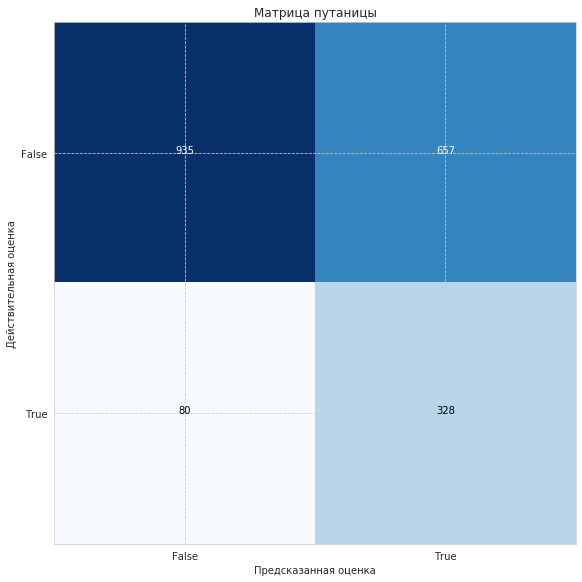

In [72]:
cnf_matrix = confusion_matrix(y_valid, predicted_valid)

print('F1: ', f1_score(y_valid, predicted_valid))
class_names = ["False","True"]
plt.figure(figsize=(16,8))
plot_confusion_matrix(cnf_matrix
                          , classes=class_names, normalize=False)

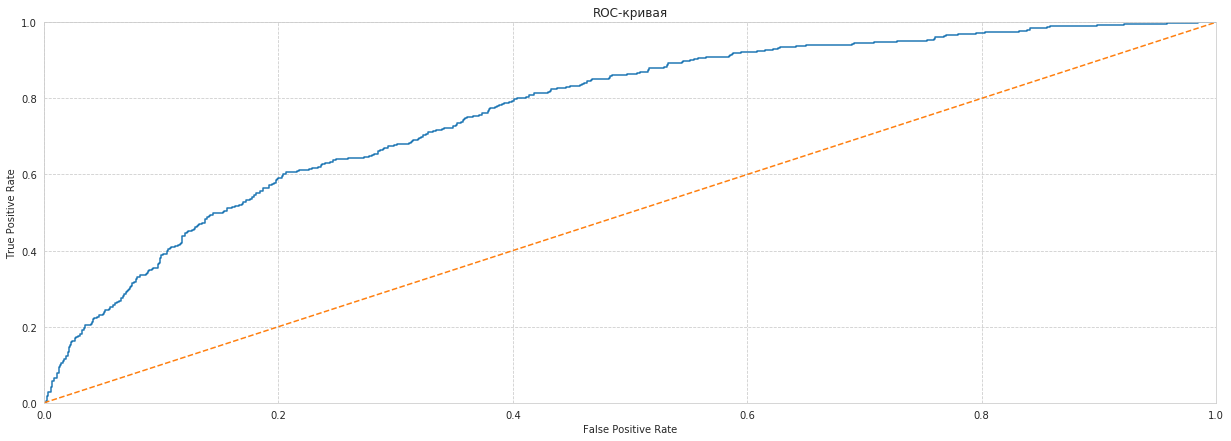

AUC-ROC:  0.7682006847965318


In [73]:
probabilities_one_valid = plot_ROC_curve(model, X_valid, y_valid)
print('AUC-ROC: ', roc_auc_score(y_valid, probabilities_one_valid))

#### Исправленная выборка

In [74]:
model, predicted_valid = logistic_regression(fix_X_train, fix_y_train, fix_X_valid, fix_y_valid, weight='balanced')


Допуск: 0.1
Accuracy:  0.658
Полнота:  0.8431372549019608
Точность:  0.35684647302904565
F1:  0.5014577259475219


F1:  0.5014577259475219


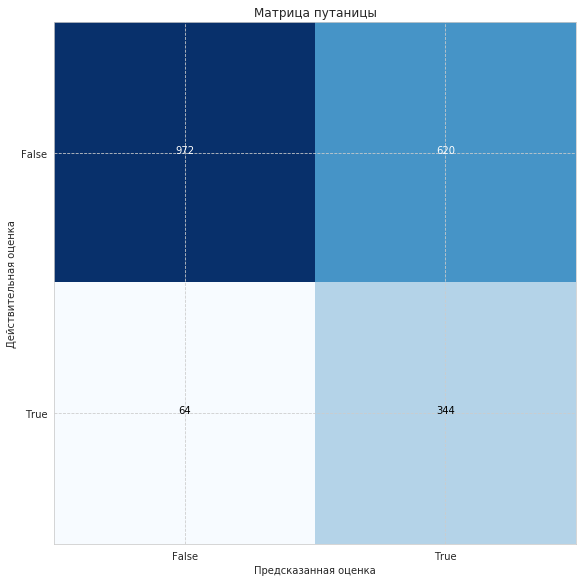

In [75]:
cnf_matrix = confusion_matrix(fix_y_valid, predicted_valid)

print('F1: ', f1_score(fix_y_valid, predicted_valid))
class_names = ["False","True"]
plt.figure(figsize=(16,8))
plot_confusion_matrix(cnf_matrix
                          , classes=class_names, normalize=False)

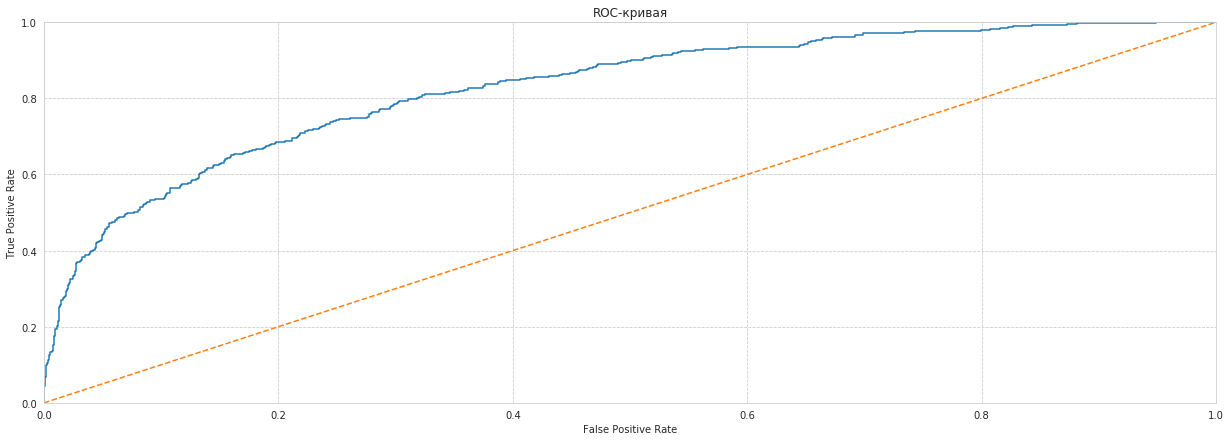

AUC-ROC:  0.8280834318652085


In [76]:
probabilities_one_valid = plot_ROC_curve(model, fix_X_valid, fix_y_valid)
print('AUC-ROC: ', roc_auc_score(fix_y_valid, probabilities_one_valid))

#### Выводы по лигистической регрессии

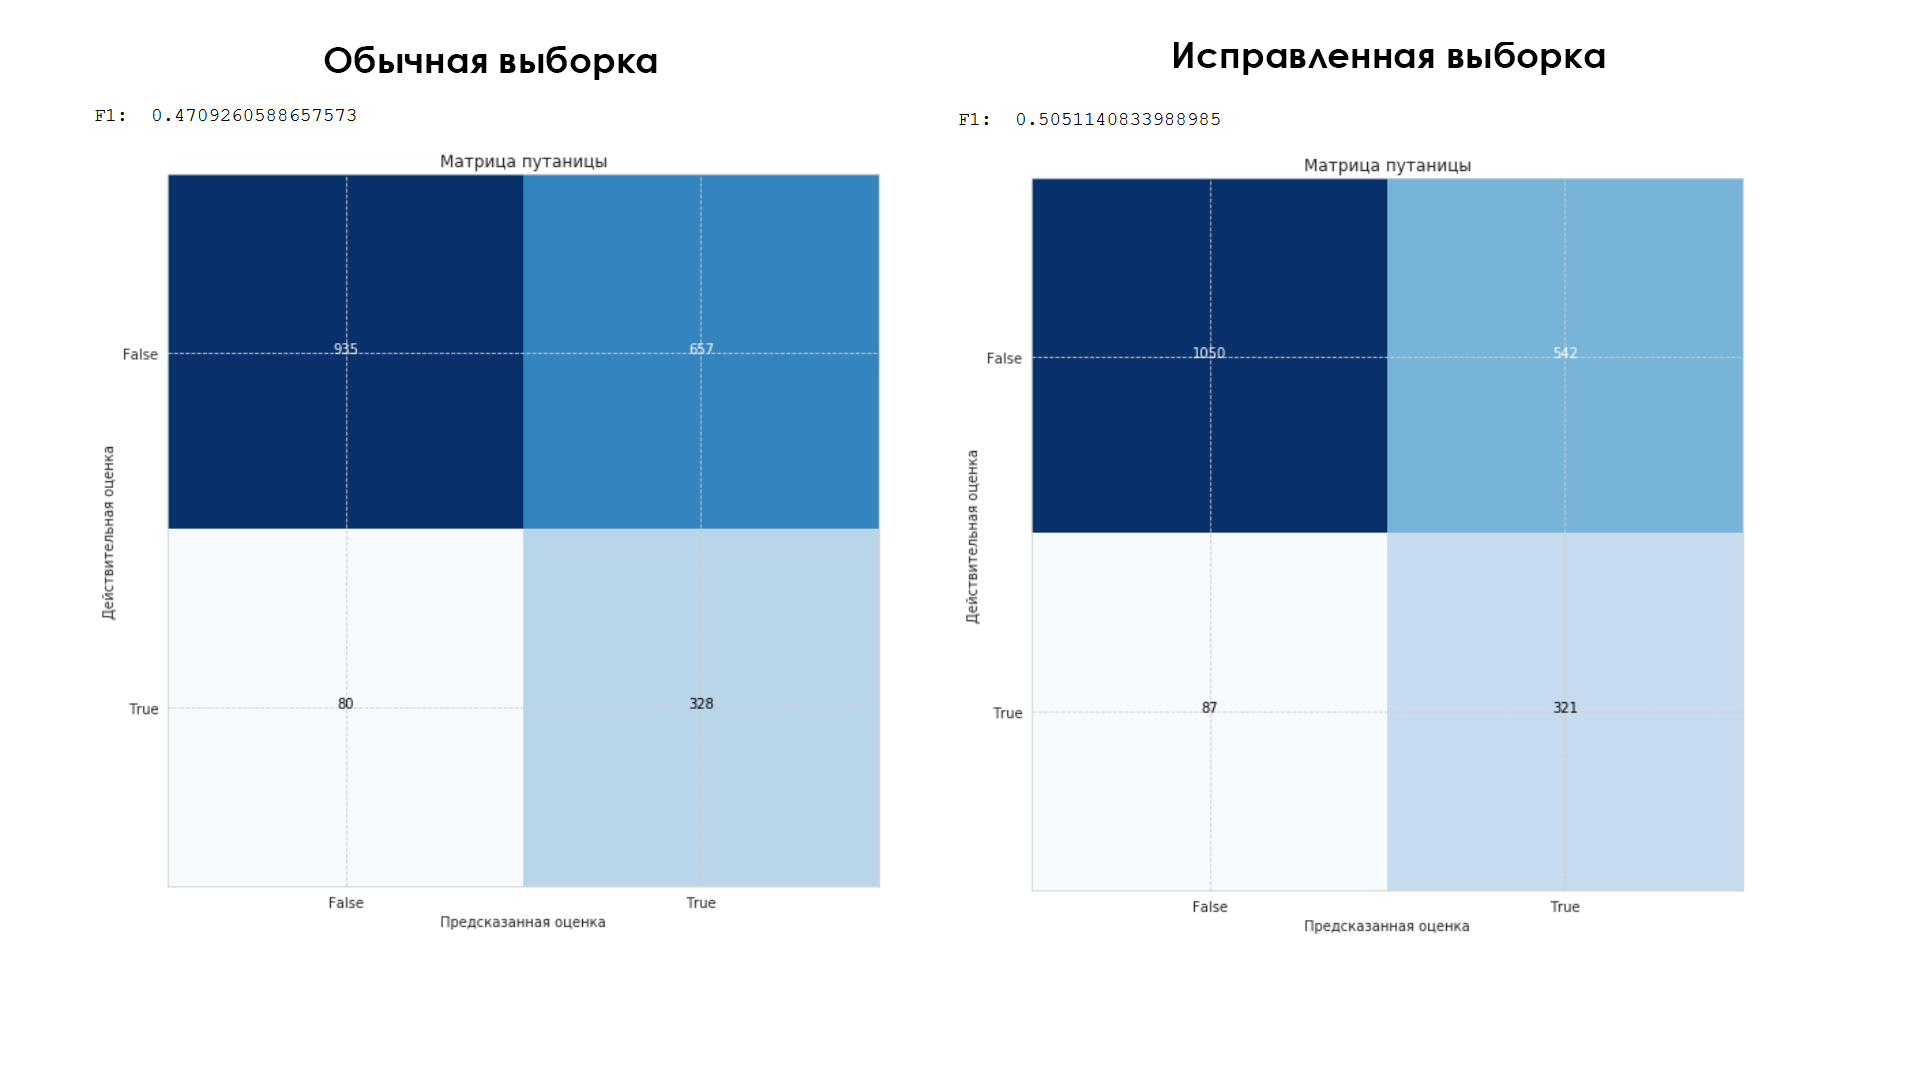

Upsampling дал свои плоды. Модели значительно лучше определяют истинно-положительный результат, однако допускают большое количество ошибок отрицательных результатах.

### Случайный лес

#### Обычная выборка

In [77]:
model, predicted_valid = random_forest(X_train, y_train, X_valid, y_valid)

Поиск оптимального числа деревьев...



Лучшая модель с  210 деревьев
Поиск оптимальной глубины...



Лучшая модель с глубиной: 19

Количество деревьев:  210 , глубина 19
Accuracy  0.8445
Полнота:  0.6102941176470589
Точность:  0.6209476309226932
F1:  0.6155747836835599


F1:  0.6155747836835599


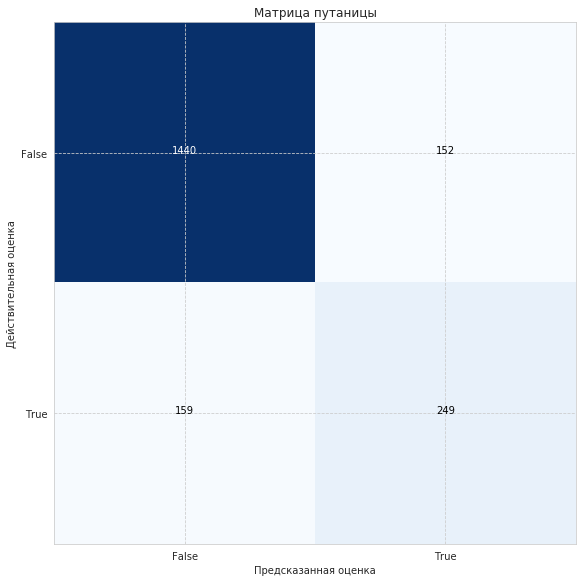

In [78]:
cnf_matrix = confusion_matrix(y_valid, predicted_valid)

print('F1: ', f1_score(y_valid, predicted_valid))
class_names = ["False","True"]
plt.figure(figsize=(16,8))
plot_confusion_matrix(cnf_matrix
                          , classes=class_names, normalize=False)

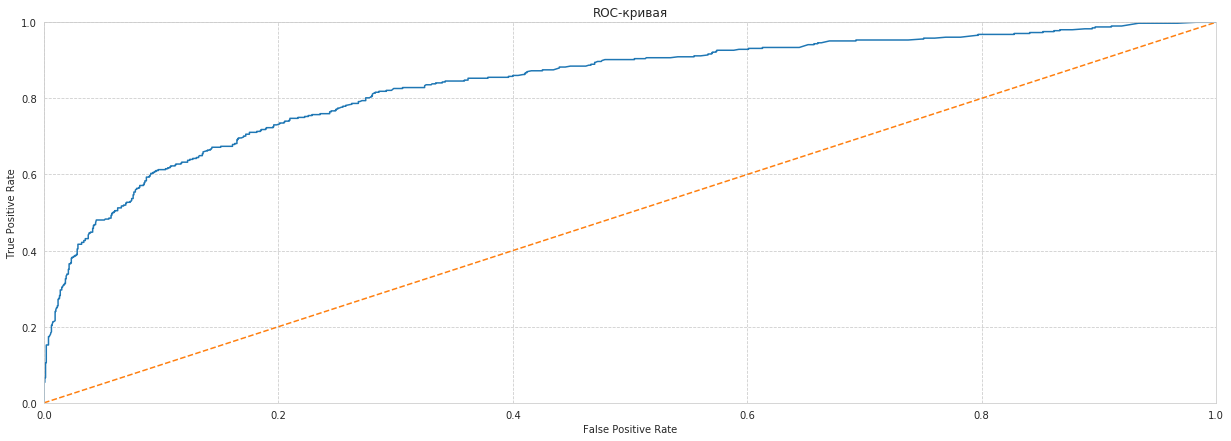

AUC-ROC:  0.8405692679081682


In [79]:
probabilities_one_valid = plot_ROC_curve(model, X_valid, y_valid)
print('AUC-ROC: ', roc_auc_score(y_valid, probabilities_one_valid))

#### Исправленная выборка

In [80]:
model, predicted_valid = random_forest(fix_X_train, fix_y_train, fix_X_valid, fix_y_valid)

Поиск оптимального числа деревьев...



Лучшая модель с  230 деревьев
Поиск оптимальной глубины...



Лучшая модель с глубиной: 23

Количество деревьев:  230 , глубина 23
Accuracy  0.8455
Полнота:  0.5857843137254902
Точность:  0.6306068601583114
F1:  0.6073697585768743


F1:  0.6073697585768743


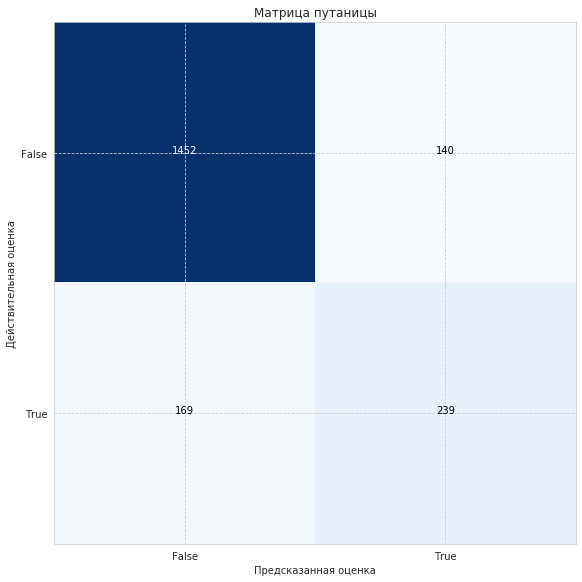

In [81]:
cnf_matrix = confusion_matrix(fix_y_valid, predicted_valid)

print('F1: ', f1_score(fix_y_valid, predicted_valid))
class_names = ["False","True"]
plt.figure(figsize=(16,8))
plot_confusion_matrix(cnf_matrix
                          , classes=class_names, normalize=False)

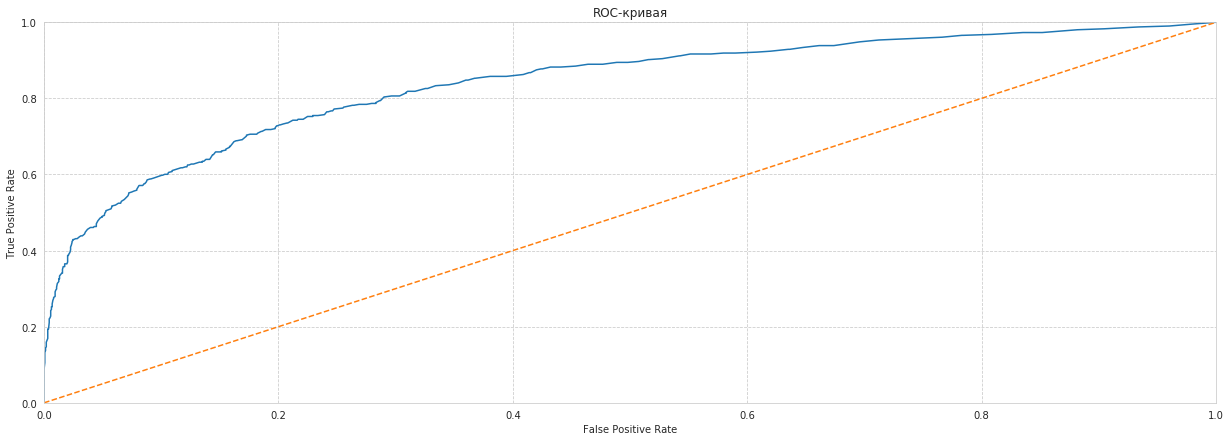

AUC-ROC:  0.8386548243669327


In [82]:
probabilities_one_valid = plot_ROC_curve(model, fix_X_valid, fix_y_valid)
print('AUC-ROC: ', roc_auc_score(fix_y_valid, probabilities_one_valid))

#### Выводы по случайному лесу

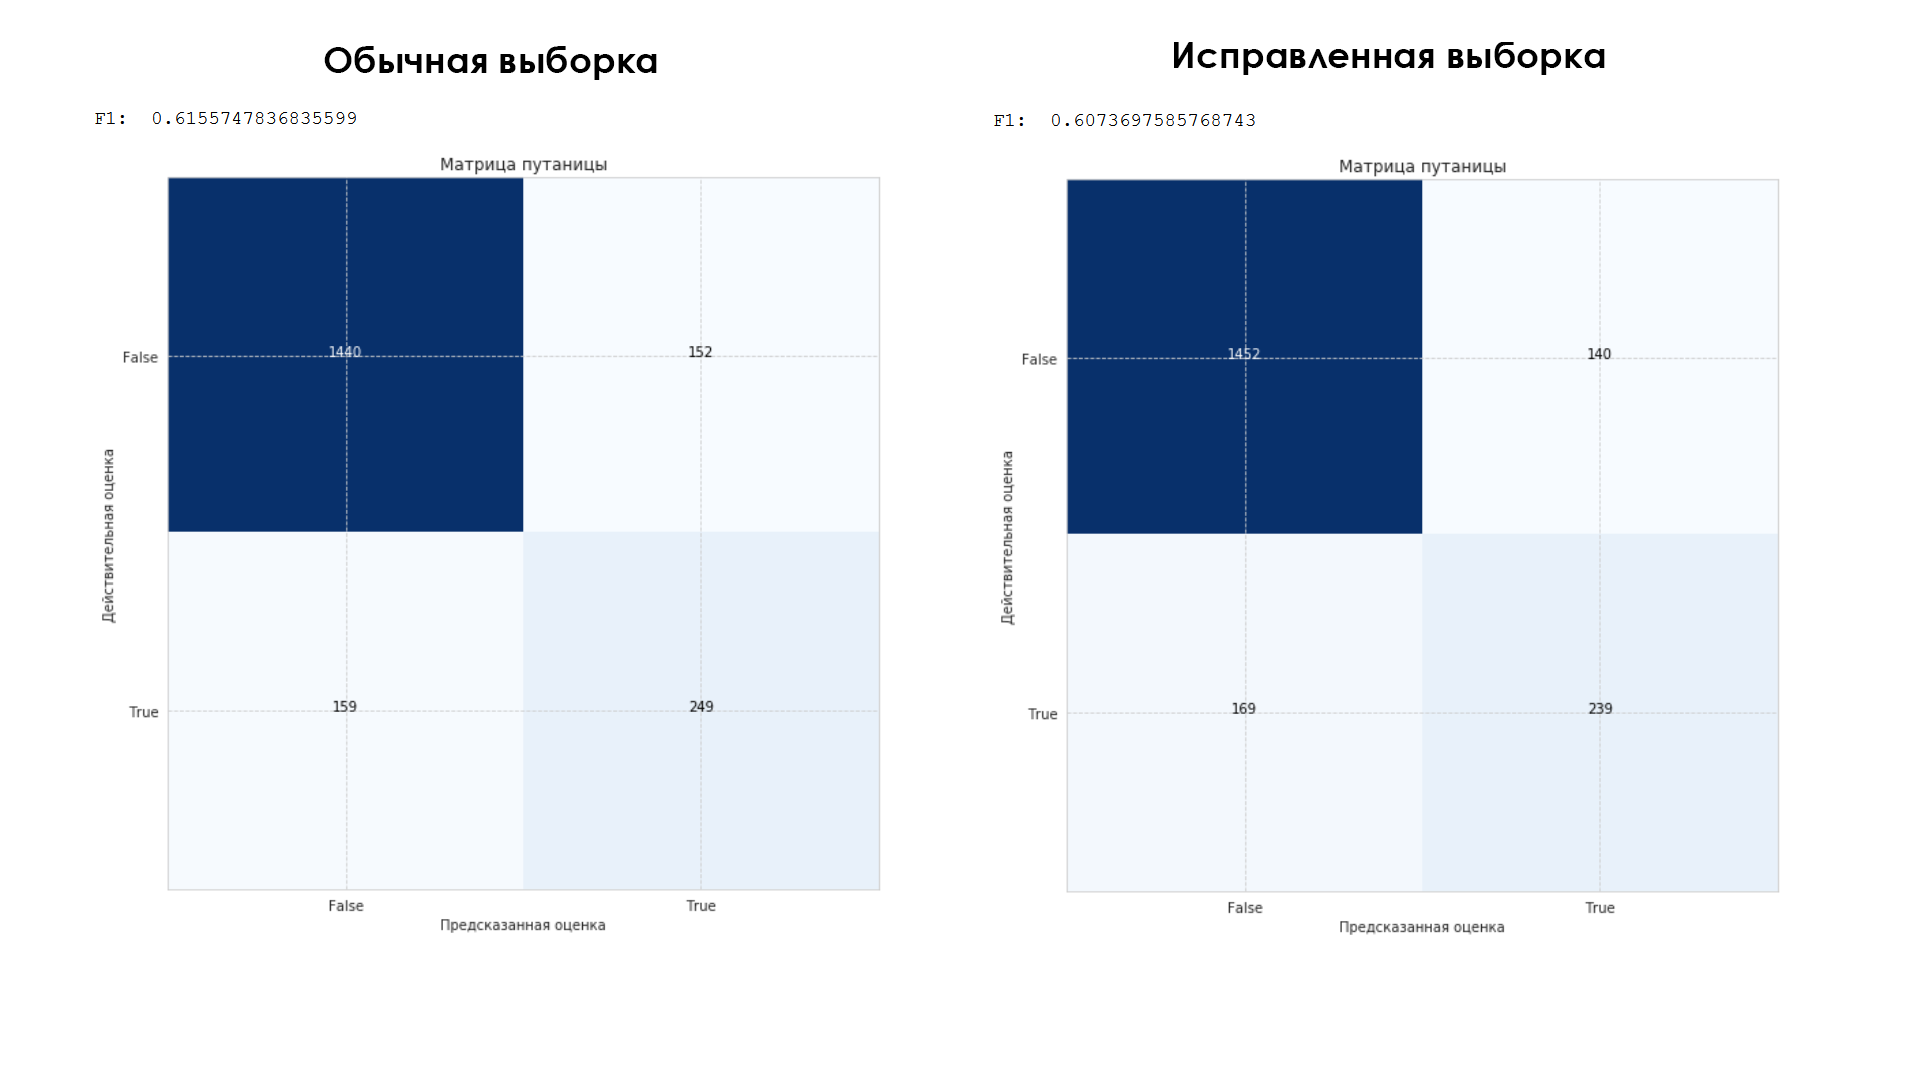

В данной ситуации первоначальная выборка дала лучший результат, чем исправленная.

### Градиентный спуск

#### Обычная выборка

In [83]:
model, predicted_valid = gradient_boosting(X_train, y_train, X_valid, y_valid)

Поиск оптимального количества итераций...



Лучшая модель с  195 итераций

Количество итераций:  195
Accuracy  0.767
Полнота:  0.7622549019607843
Точность:  0.4573529411764706
F1:  0.5716911764705883


F1:  0.5716911764705883


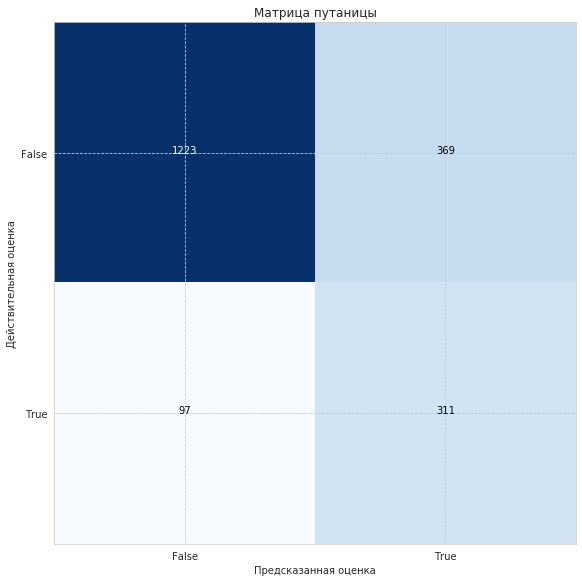

In [84]:
cnf_matrix = confusion_matrix(y_valid, predicted_valid)

print('F1: ', f1_score(y_valid, predicted_valid))
class_names = ["False","True"]
plt.figure(figsize=(16,8))
plot_confusion_matrix(cnf_matrix
                          , classes=class_names, normalize=False)

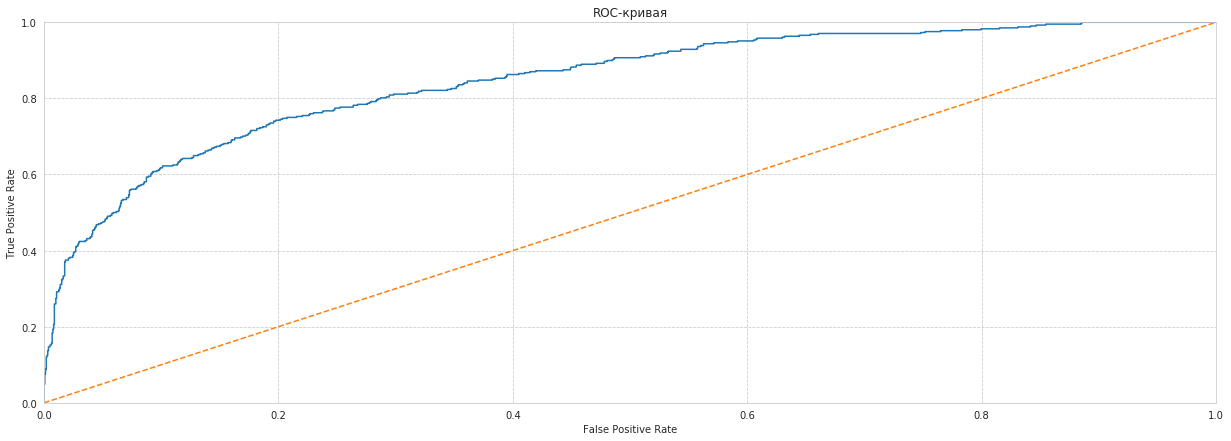

AUC-ROC:  0.8476935843432851


In [85]:
probabilities_one_valid = plot_ROC_curve(model, X_valid, y_valid)
print('AUC-ROC: ', roc_auc_score(y_valid, probabilities_one_valid))

#### Исправленная выборка

In [86]:
model, predicted_valid = gradient_boosting(fix_X_train, fix_y_train, fix_X_valid, fix_y_valid)

Поиск оптимального количества итераций...



Лучшая модель с  165 итераций

Количество итераций:  165
Accuracy  0.774
Полнота:  0.7720588235294118
Точность:  0.46735905044510384
F1:  0.5822550831792975


F1:  0.5822550831792975


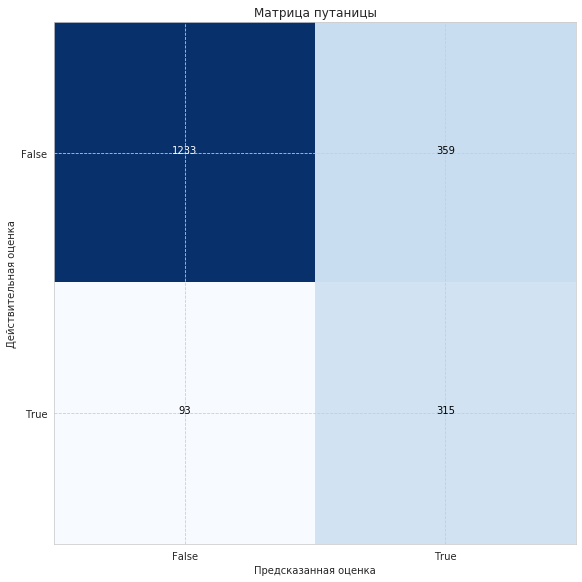

In [87]:
cnf_matrix = confusion_matrix(fix_y_valid, predicted_valid)

print('F1: ', f1_score(fix_y_valid, predicted_valid))
class_names = ["False","True"]
plt.figure(figsize=(16,8))
plot_confusion_matrix(cnf_matrix
                          , classes=class_names, normalize=False)

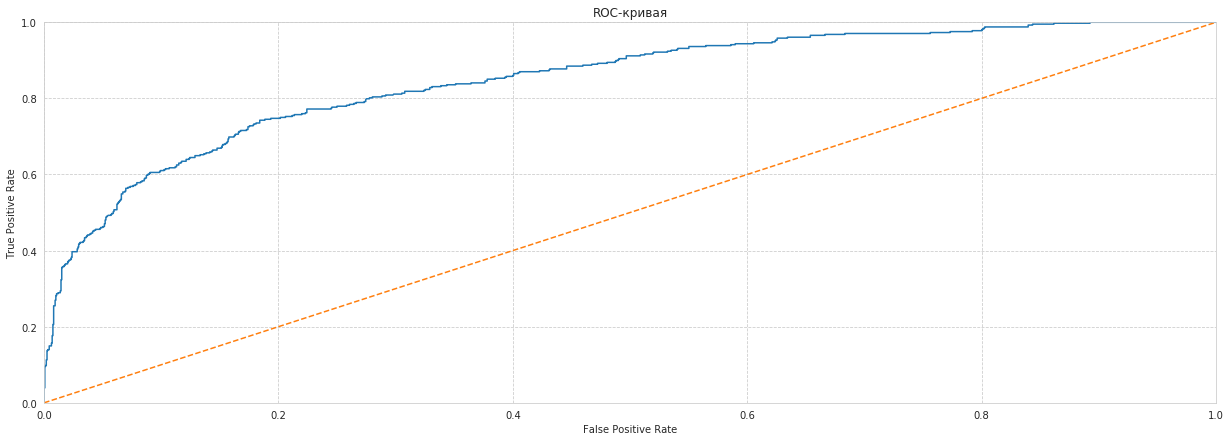

AUC-ROC:  0.8488190031037542


In [88]:
probabilities_one_valid = plot_ROC_curve(model, fix_X_valid, fix_y_valid)
print('AUC-ROC: ', roc_auc_score(fix_y_valid, probabilities_one_valid))

#### Выводы по градиентному спуску

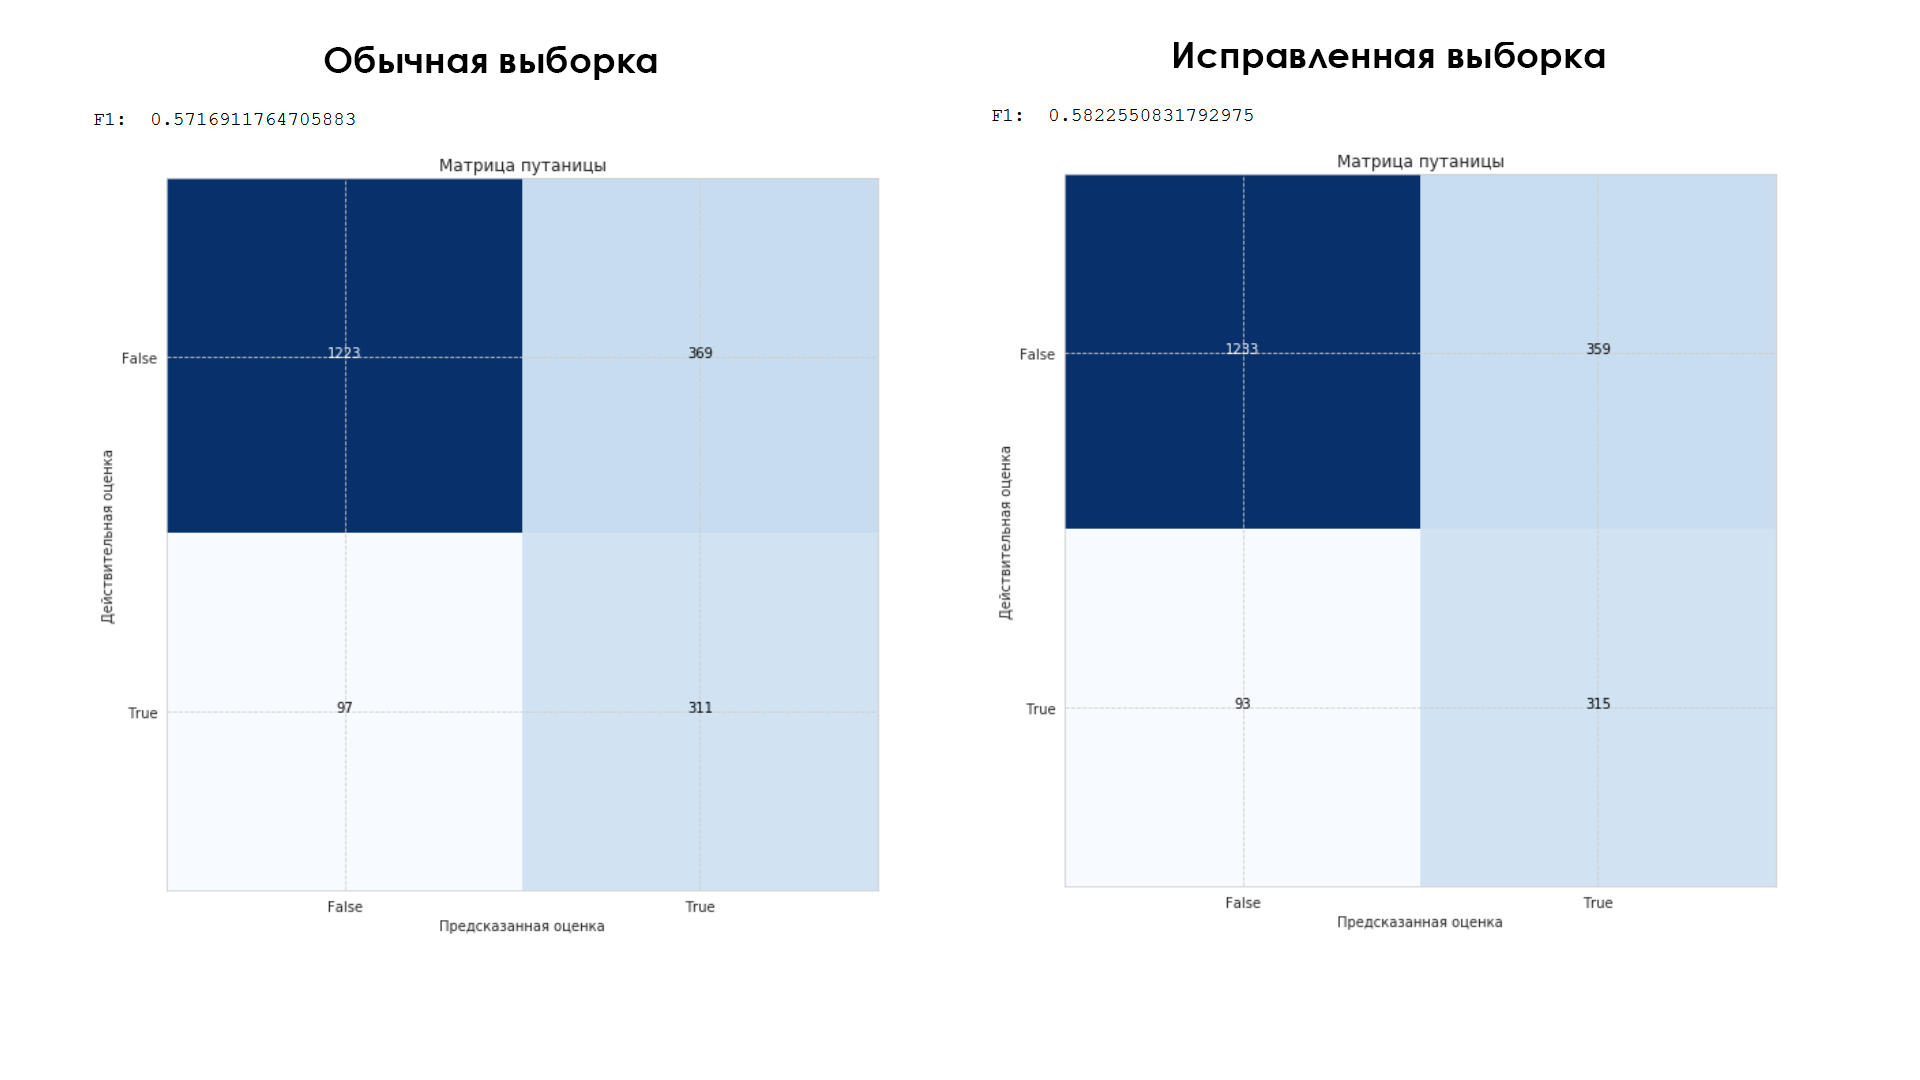

Градиентный спуск показал плохие результаты, и не смог достигнуть нужной границы.

### Выводы по upsampling

Upsampling хорошо работает в случайном лесу, и позволяет пересечь границу минимального значения f1.

## Downsampling

Суть downsampling в том, чтобы уменьшить количество "доминирующего класса". На данных в этой работе он показал себя очень плохо.

### Предобработка выборок

#### Обычная выборка

In [89]:
X_train, X_valid, X_test, y_train, y_valid, y_test = normalized_train_valid_test_split(main_feature='Exited', 
                                                                            data=data_churn, 
                                                                            random_state=123, 
                                                                            downsampling=True, 
                                                                            downsampling_rate=0.15)

Процент ушедших из банка в тренировочной выборке: 50.6%
Процент ушедших из банка в валидационной выборке: 10.8%
Процент ушедших из банка в тестовой выборке: 10.7%


In [90]:
print('Количество тренировочных признаков:',len(X_train))
print('Количество тренировочных целевых признаков:',len(y_train))
print('')
print('Количество валидационных признаков:',len(X_valid))
print('Количество валидационных целевых признаков:',len(y_valid))
print('')
print('Количество тестовых признаков:',len(X_test))
print('Количество тестовых целевых признаков:',len(y_test))

Количество тренировочных признаков: 2416
Количество тренировочных целевых признаков: 2416

Количество валидационных признаков: 3792
Количество валидационных целевых признаков: 3792

Количество тестовых признаков: 3792
Количество тестовых целевых признаков: 3792


#### Исправленная выборка

In [91]:
fix_X_train, fix_X_valid, fix_X_test, fix_y_train, fix_y_valid, fix_y_test = normalized_train_valid_test_split(main_feature='Exited', 
                                                                            data=fixed_data_churn, 
                                                                            random_state=123, 
                                                                            downsampling=True, 
                                                                            downsampling_rate=0.15)

Процент ушедших из банка в тренировочной выборке: 50.6%
Процент ушедших из банка в валидационной выборке: 10.8%
Процент ушедших из банка в тестовой выборке: 10.7%


In [92]:
print('Количество тренировочных признаков:',len(fix_X_train))
print('Количество тренировочных целевых признаков:',len(fix_y_train))
print('')
print('Количество валидационных признаков:',len(fix_X_valid))
print('Количество валидационных целевых признаков:',len(fix_y_valid))
print('')
print('Количество тестовых признаков:',len(fix_X_test))
print('Количество тестовых целевых признаков:',len(fix_y_test))

Количество тренировочных признаков: 2416
Количество тренировочных целевых признаков: 2416

Количество валидационных признаков: 3792
Количество валидационных целевых признаков: 3792

Количество тестовых признаков: 3792
Количество тестовых целевых признаков: 3792


### Логистическая регрессия

#### Обычная выборка

In [93]:
model, predicted_valid = logistic_regression(X_train, y_train, X_valid, y_valid, weight='balanced')


Допуск: 0.001
Accuracy:  0.5928270042194093
Полнота:  0.8529411764705882
Точность:  0.18995633187772926
F1:  0.3107142857142857


F1:  0.3107142857142857


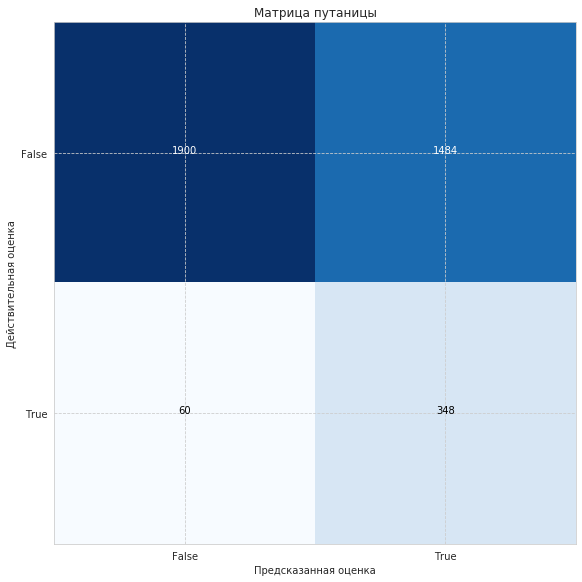

In [94]:
cnf_matrix = confusion_matrix(y_valid, predicted_valid)

print('F1: ', f1_score(y_valid, predicted_valid))
class_names = ["False","True"]
plt.figure(figsize=(16,8))
plot_confusion_matrix(cnf_matrix
                          , classes=class_names, normalize=False)

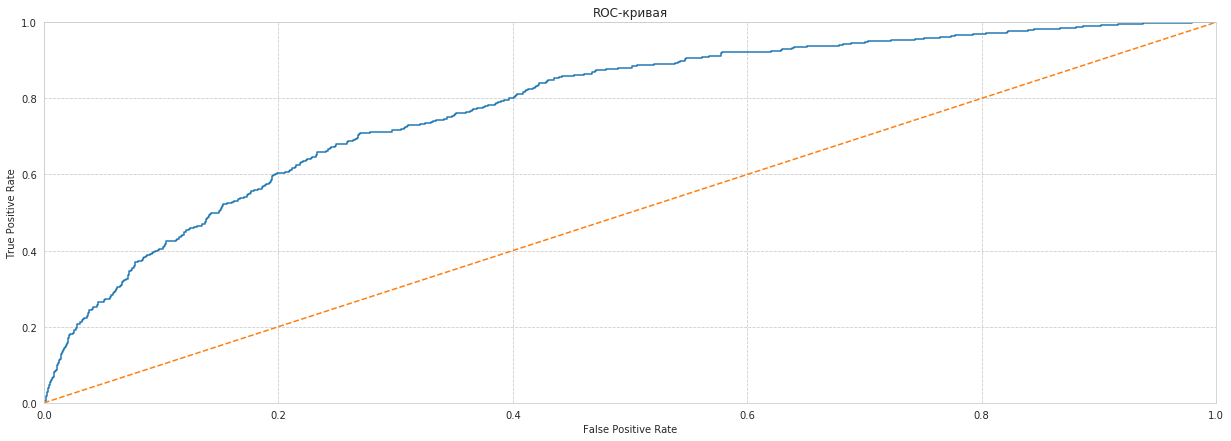

AUC-ROC:  0.781024023084411


In [95]:
probabilities_one_valid = plot_ROC_curve(model, X_valid, y_valid)
print('AUC-ROC: ', roc_auc_score(y_valid, probabilities_one_valid))

#### Исправленная выборка

In [96]:
model, predicted_valid = logistic_regression(fix_X_train, fix_y_train, fix_X_valid, fix_y_valid, weight='balanced')


Допуск: 0.0001
Accuracy:  0.6679852320675106
Полнота:  0.7892156862745098
Точность:  0.2153846153846154
F1:  0.33841303205465056


F1:  0.33841303205465056


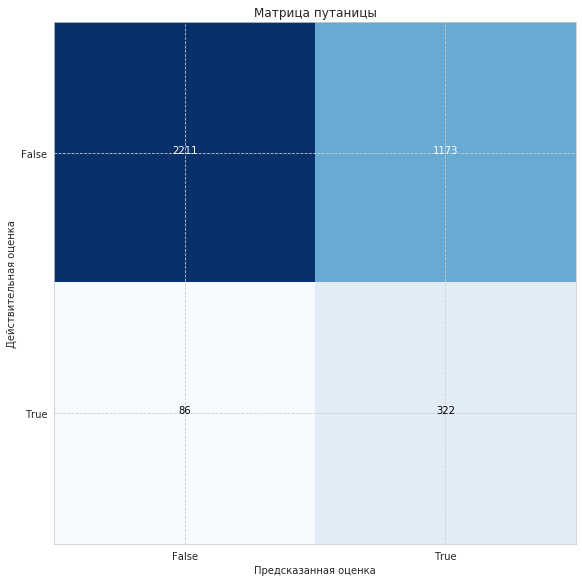

In [97]:
cnf_matrix = confusion_matrix(fix_y_valid, predicted_valid)

print('F1: ', f1_score(fix_y_valid, predicted_valid))
class_names = ["False","True"]
plt.figure(figsize=(16,8))
plot_confusion_matrix(cnf_matrix
                          , classes=class_names, normalize=False)

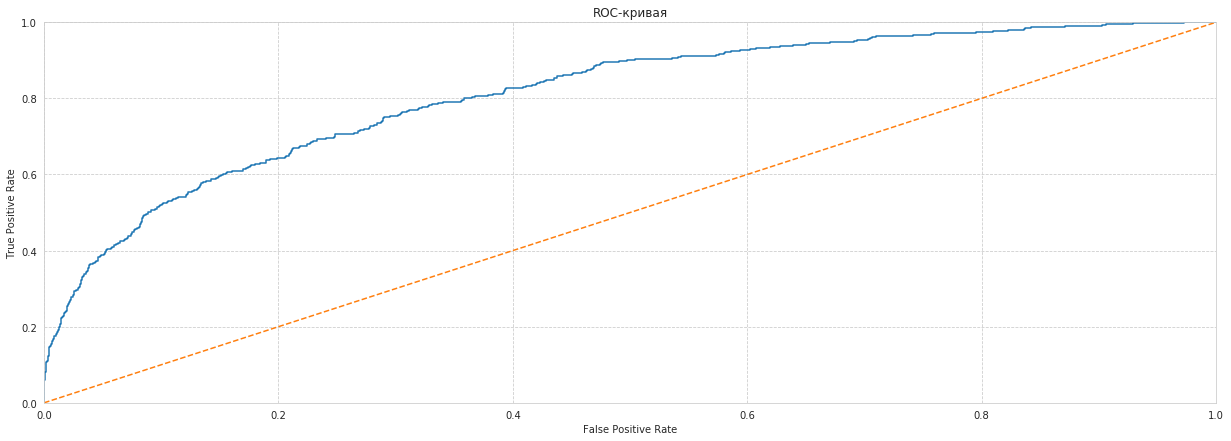

AUC-ROC:  0.810752300329115


In [98]:
probabilities_one_valid = plot_ROC_curve(model, fix_X_valid, fix_y_valid)
print('AUC-ROC: ', roc_auc_score(fix_y_valid, probabilities_one_valid))

### Случайный лес

#### Обычная выборка

In [99]:
model, predicted_valid = random_forest(X_train, y_train, X_valid, y_valid)

Поиск оптимального числа деревьев...



Лучшая модель с  210 деревьев
Поиск оптимальной глубины...



Лучшая модель с глубиной: 9

Количество деревьев:  210 , глубина 9
Accuracy  0.734704641350211
Полнота:  0.8014705882352942
Точность:  0.26118210862619806
F1:  0.39397590361445783


F1:  0.39397590361445783


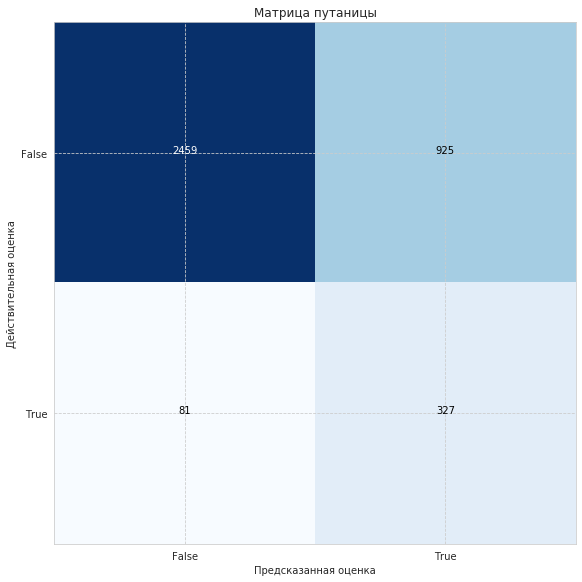

In [100]:
cnf_matrix = confusion_matrix(y_valid, predicted_valid)

print('F1: ', f1_score(y_valid, predicted_valid))
class_names = ["False","True"]
plt.figure(figsize=(16,8))
plot_confusion_matrix(cnf_matrix
                          , classes=class_names, normalize=False)

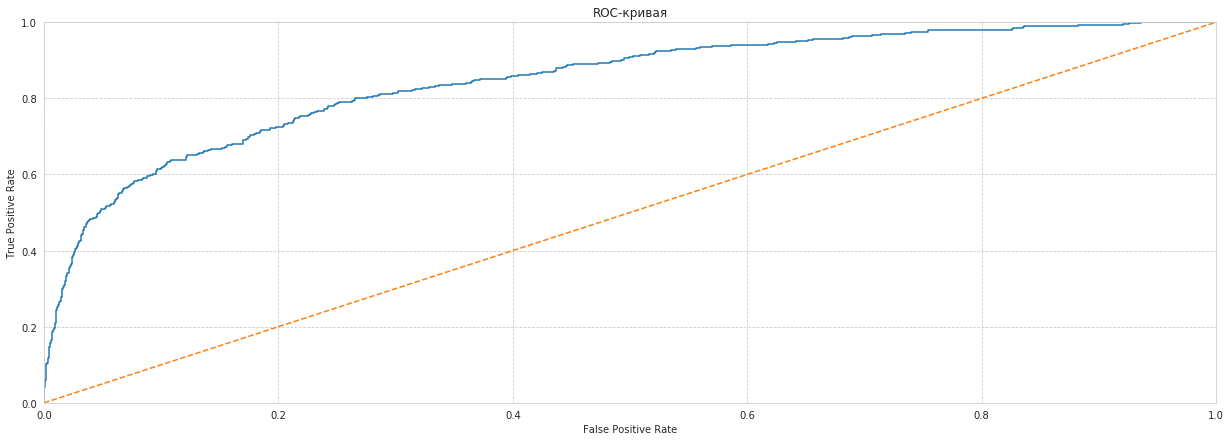

AUC-ROC:  0.8470512909655588


In [101]:
probabilities_one_valid = plot_ROC_curve(model, X_valid, y_valid)
print('AUC-ROC: ', roc_auc_score(y_valid, probabilities_one_valid))

#### Исправленная выборка

In [102]:
model, predicted_valid = random_forest(fix_X_train, fix_y_train, fix_X_valid, fix_y_valid)

Поиск оптимального числа деревьев...



Лучшая модель с  210 деревьев
Поиск оптимальной глубины...



Лучшая модель с глубиной: 8

Количество деревьев:  210 , глубина 8
Accuracy  0.7639767932489452
Полнота:  0.7867647058823529
Точность:  0.2843224092116918
F1:  0.41769681197137287


F1:  0.41769681197137287


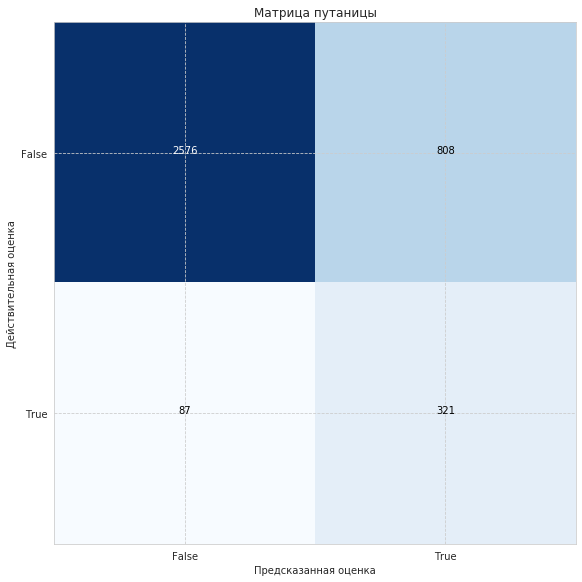

In [103]:
cnf_matrix = confusion_matrix(fix_y_valid, predicted_valid)

print('F1: ', f1_score(fix_y_valid, predicted_valid))
class_names = ["False","True"]
plt.figure(figsize=(16,8))
plot_confusion_matrix(cnf_matrix
                          , classes=class_names, normalize=False)

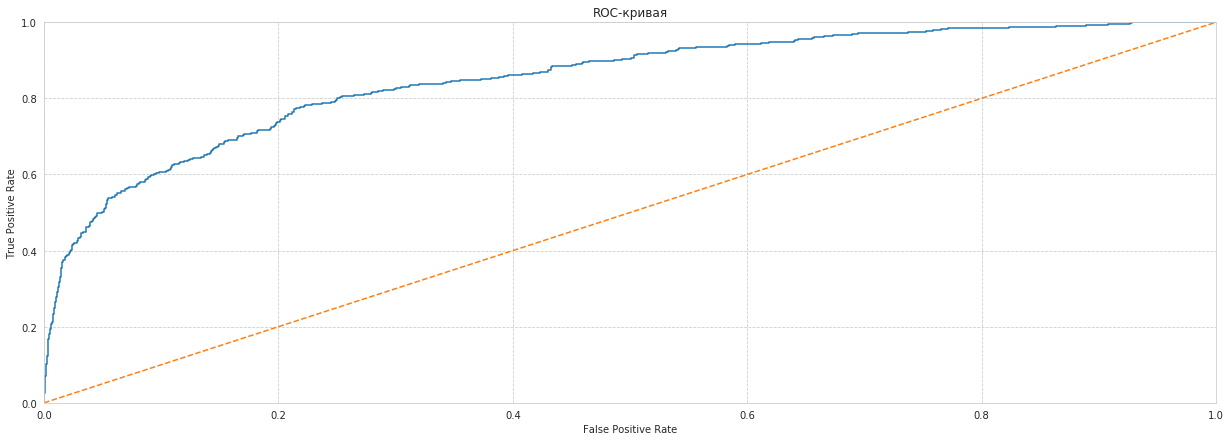

AUC-ROC:  0.8514600136745006


In [104]:
probabilities_one_valid = plot_ROC_curve(model, fix_X_valid, fix_y_valid)
print('AUC-ROC: ', roc_auc_score(fix_y_valid, probabilities_one_valid))

### Градиентный спуск

#### Обычная выборка

In [105]:
model, predicted_valid = gradient_boosting(X_train, y_train, X_valid, y_valid)

Поиск оптимального количества итераций...



Лучшая модель с  55 итераций

Количество итераций:  55
Accuracy  0.7402426160337553
Полнота:  0.7965686274509803
Точность:  0.26487367563162184
F1:  0.39755351681957185


F1:  0.39755351681957185


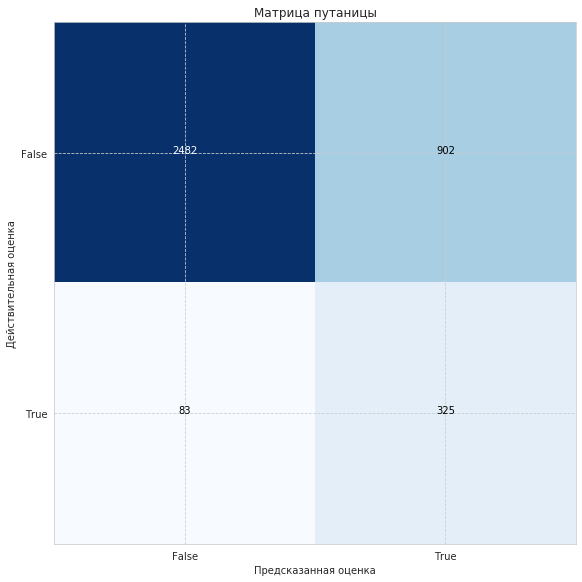

In [106]:
cnf_matrix = confusion_matrix(y_valid, predicted_valid)

print('F1: ', f1_score(y_valid, predicted_valid))
class_names = ["False","True"]
plt.figure(figsize=(16,8))
plot_confusion_matrix(cnf_matrix
                          , classes=class_names, normalize=False)

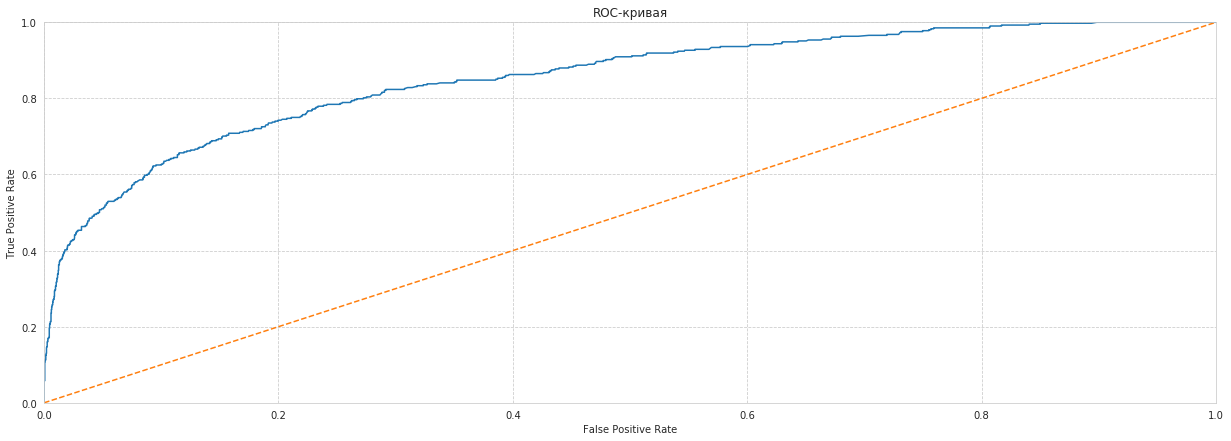

AUC-ROC:  0.8530523542159181


In [107]:
probabilities_one_valid = plot_ROC_curve(model, X_valid, y_valid)
print('AUC-ROC: ', roc_auc_score(y_valid, probabilities_one_valid))

#### Исправленная выборка

In [108]:
model, predicted_valid = gradient_boosting(fix_X_train, fix_y_train, fix_X_valid, fix_y_valid)

Поиск оптимального количества итераций...



Лучшая модель с  65 итераций

Количество итераций:  65
Accuracy  0.7399789029535865
Полнота:  0.803921568627451
Точность:  0.26580226904376014
F1:  0.39951278928136413


F1:  0.39951278928136413


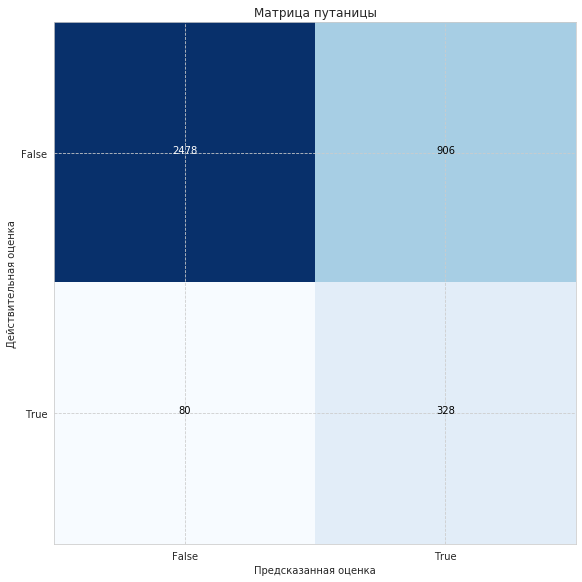

In [109]:
cnf_matrix = confusion_matrix(fix_y_valid, predicted_valid)

print('F1: ', f1_score(fix_y_valid, predicted_valid))
class_names = ["False","True"]
plt.figure(figsize=(16,8))
plot_confusion_matrix(cnf_matrix
                          , classes=class_names, normalize=False)

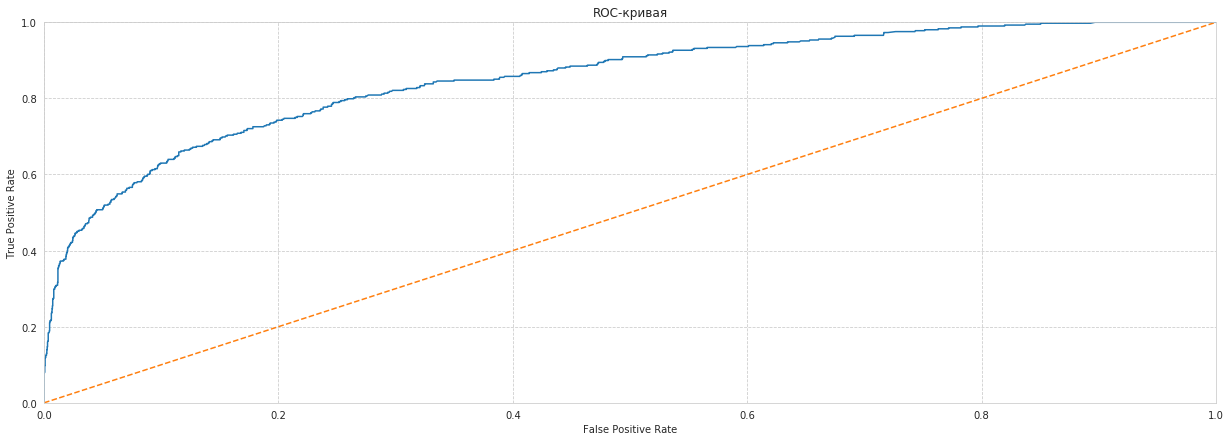

AUC-ROC:  0.8531595483938257


In [110]:
probabilities_one_valid = plot_ROC_curve(model, fix_X_valid, fix_y_valid)
print('AUC-ROC: ', roc_auc_score(fix_y_valid, probabilities_one_valid))

### Выводы по downsampling

Качество модели сильно падает, поэтому в данной работе этот метод слабо применим.

## Изменение порога

Для проверки эффективности метода изменения порога, будут выбраны самые удачные обученные модели, а именно модели с примененным методом upsampling и обученные алгоритмом "случайный лес". 

### Предобработка выборок

#### Обычная выборка

In [111]:
X_train, X_valid, X_test, y_train, y_valid, y_test = normalized_train_valid_test_split(main_feature='Exited', 
                                                                            data=data_churn, 
                                                                            random_state=123, 
                                                                            upsampling=True, 
                                                                            upsampling_rate=4)

Процент ушедших из банка в тренировочной выборке: 50.6%
Процент ушедших из банка в валидационной выборке: 20.4%
Процент ушедших из банка в тестовой выборке: 20.3%


In [112]:
print('Количество тренировочных признаков:',len(X_train))
print('Количество тренировочных целевых признаков:',len(y_train))
print('')
print('Количество валидационных признаков:',len(X_valid))
print('Количество валидационных целевых признаков:',len(y_valid))
print('')
print('Количество тестовых признаков:',len(X_test))
print('Количество тестовых целевых признаков:',len(y_test))

Количество тренировочных признаков: 9666
Количество тренировочных целевых признаков: 9666

Количество валидационных признаков: 2000
Количество валидационных целевых признаков: 2000

Количество тестовых признаков: 2000
Количество тестовых целевых признаков: 2000


#### Исправленная выборка

In [113]:
fix_X_train, fix_X_valid, fix_X_test, fix_y_train, fix_y_valid, fix_y_test = normalized_train_valid_test_split(main_feature='Exited', 
                                                                            data=fixed_data_churn, 
                                                                            random_state=123, 
                                                                            upsampling=True, 
                                                                            upsampling_rate=4)

Процент ушедших из банка в тренировочной выборке: 50.6%
Процент ушедших из банка в валидационной выборке: 20.4%
Процент ушедших из банка в тестовой выборке: 20.3%


In [114]:
print('Количество тренировочных признаков:',len(fix_X_train))
print('Количество тренировочных целевых признаков:',len(fix_y_train))
print('')
print('Количество валидационных признаков:',len(fix_X_valid))
print('Количество валидационных целевых признаков:',len(fix_y_valid))
print('')
print('Количество тестовых признаков:',len(fix_X_test))
print('Количество тестовых целевых признаков:',len(fix_y_test))

Количество тренировочных признаков: 9666
Количество тренировочных целевых признаков: 9666

Количество валидационных признаков: 2000
Количество валидационных целевых признаков: 2000

Количество тестовых признаков: 2000
Количество тестовых целевых признаков: 2000


### Случайный лес

#### Обычная выборка

In [115]:
model, predicted_valid = random_forest(X_train, y_train, X_valid, y_valid)

Поиск оптимального числа деревьев...



Лучшая модель с  210 деревьев
Поиск оптимальной глубины...



Лучшая модель с глубиной: 19

Количество деревьев:  210 , глубина 19
Accuracy  0.8445
Полнота:  0.6102941176470589
Точность:  0.6209476309226932
F1:  0.6155747836835599


In [116]:
probabilities_valid = model.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]

Порог = 0.30, Точность = 0.441, Полнота = 0.775 F1:  0.5617777777777778


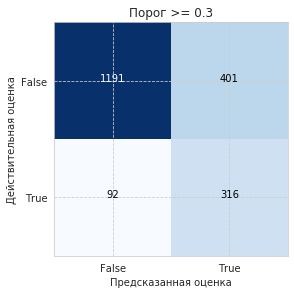

------------------------------------------------------------------------

Порог = 0.35, Точность = 0.480, Полнота = 0.735 F1:  0.5808325266214909


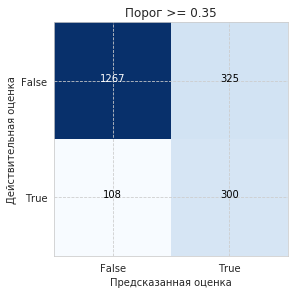

------------------------------------------------------------------------

Порог = 0.40, Точность = 0.517, Полнота = 0.694 F1:  0.5926701570680629


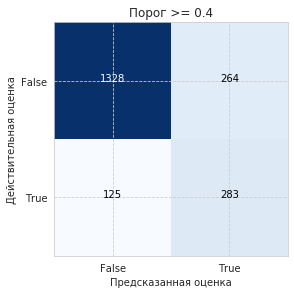

------------------------------------------------------------------------

Порог = 0.45, Точность = 0.556, Полнота = 0.645 F1:  0.5970488081725313


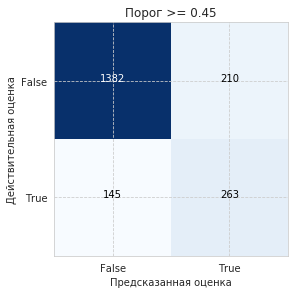

------------------------------------------------------------------------

Порог = 0.50, Точность = 0.619, Полнота = 0.610 F1:  0.6148148148148149


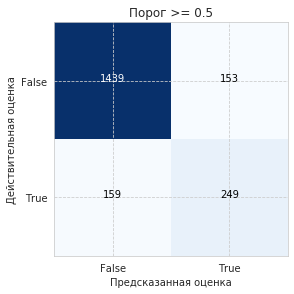

------------------------------------------------------------------------

Порог = 0.55, Точность = 0.647, Полнота = 0.549 F1:  0.5941644562334218


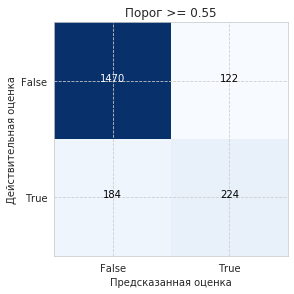

------------------------------------------------------------------------



In [117]:
for threshold in np.arange(0.3, 0.6, 0.05):
    predicted_valid = binarize(probabilities_one_valid.reshape(-1,1), threshold)
    cnf_matrix = confusion_matrix(y_valid, predicted_valid)
    precision = precision_score(y_valid, predicted_valid)
    recall = recall_score(y_valid, predicted_valid)
    print("Порог = {:.2f}, Точность = {:.3f}, Полнота = {:.3f}".format(threshold, precision, recall),'F1: ', f1_score(y_valid, predicted_valid))
    class_names = ["False","True"]
    plot_confusion_matrix(cnf_matrix
                          , classes=class_names
                          , title='Порог >= {:.2}'.format(threshold))
    print('------------------------------------------------------------------------')
    print('')

#### Исправленная выборка

In [118]:
model, predicted_valid = random_forest(fix_X_train, fix_y_train, fix_X_valid, fix_y_valid)

Поиск оптимального числа деревьев...



Лучшая модель с  230 деревьев
Поиск оптимальной глубины...



Лучшая модель с глубиной: 23

Количество деревьев:  230 , глубина 23
Accuracy  0.8455
Полнота:  0.5857843137254902
Точность:  0.6306068601583114
F1:  0.6073697585768743


In [119]:
probabilities_valid = model.predict_proba(fix_X_valid)
probabilities_one_valid = probabilities_valid[:, 1]

Порог = 0.30, Точность = 0.453, Полнота = 0.755 F1:  0.5661764705882353


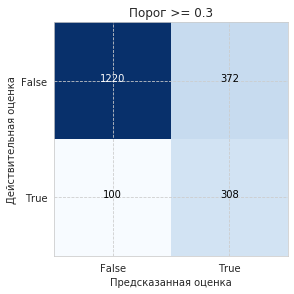

------------------------------------------------------------------------

Порог = 0.35, Точность = 0.484, Полнота = 0.728 F1:  0.5812133072407044


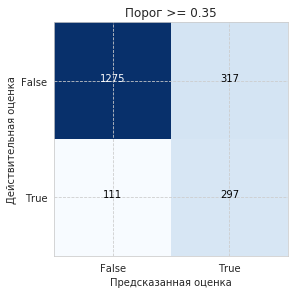

------------------------------------------------------------------------

Порог = 0.40, Точность = 0.521, Полнота = 0.672 F1:  0.5867237687366167


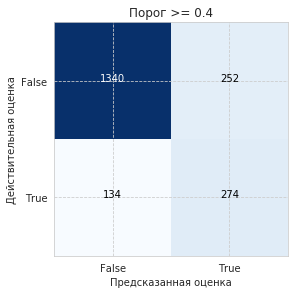

------------------------------------------------------------------------

Порог = 0.45, Точность = 0.561, Полнота = 0.627 F1:  0.5925925925925926


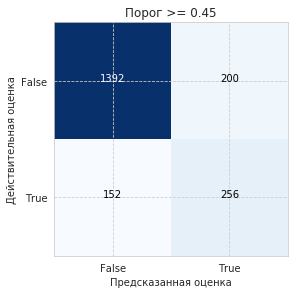

------------------------------------------------------------------------

Порог = 0.50, Точность = 0.625, Полнота = 0.588 F1:  0.6060606060606061


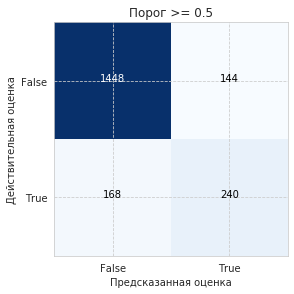

------------------------------------------------------------------------

Порог = 0.55, Точность = 0.673, Полнота = 0.529 F1:  0.5925925925925926


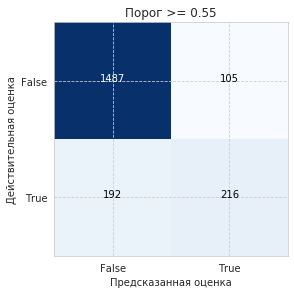

------------------------------------------------------------------------



In [120]:
for threshold in np.arange(0.3, 0.6, 0.05):
    predicted_valid = binarize(probabilities_one_valid.reshape(-1,1), threshold)
    cnf_matrix = confusion_matrix(fix_y_valid, predicted_valid)
    precision = precision_score(fix_y_valid, predicted_valid)
    recall = recall_score(fix_y_valid, predicted_valid)
    print("Порог = {:.2f}, Точность = {:.3f}, Полнота = {:.3f}".format(threshold, precision, recall),'F1: ', f1_score(y_valid, predicted_valid))
    class_names = ["False","True"]
    plot_confusion_matrix(cnf_matrix
                          , classes=class_names
                          , title='Порог >= {:.2}'.format(threshold))
    print('------------------------------------------------------------------------')
    print('')

Оптимальным порогом на обоих выборках оказался 0.5. 

# 4. Тестирование модели

In [121]:
model, predicted_valid = random_forest(X_train, y_train, X_valid, y_valid)

Поиск оптимального числа деревьев...



Лучшая модель с  210 деревьев
Поиск оптимальной глубины...



Лучшая модель с глубиной: 19

Количество деревьев:  210 , глубина 19
Accuracy  0.8445
Полнота:  0.6102941176470589
Точность:  0.6209476309226932
F1:  0.6155747836835599


In [122]:
probabilities_test = model.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]
predicted_test = binarize(probabilities_one_test.reshape(-1,1), 0.5)

In [123]:
print('Accuracy ', accuracy_score(y_test, predicted_test))
print('Полнота: ', recall_score(y_test, predicted_test))
print('Точность: ', precision_score(y_test, predicted_test))
print('F1: ', f1_score(y_test, predicted_test))

Accuracy  0.843
Полнота:  0.6191646191646192
Точность:  0.6131386861313869
F1:  0.6161369193154034


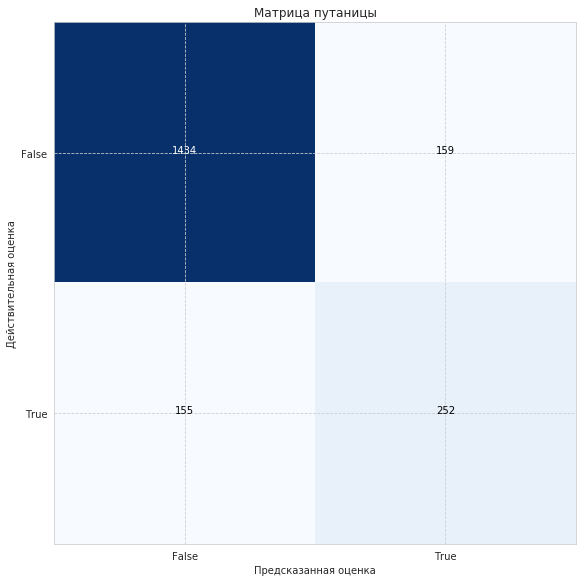

In [124]:
cnf_matrix = confusion_matrix(y_test, predicted_test)

class_names = ["False","True"]
plt.figure(figsize=(16,8))
plot_confusion_matrix(cnf_matrix
                          , classes=class_names, normalize=False)

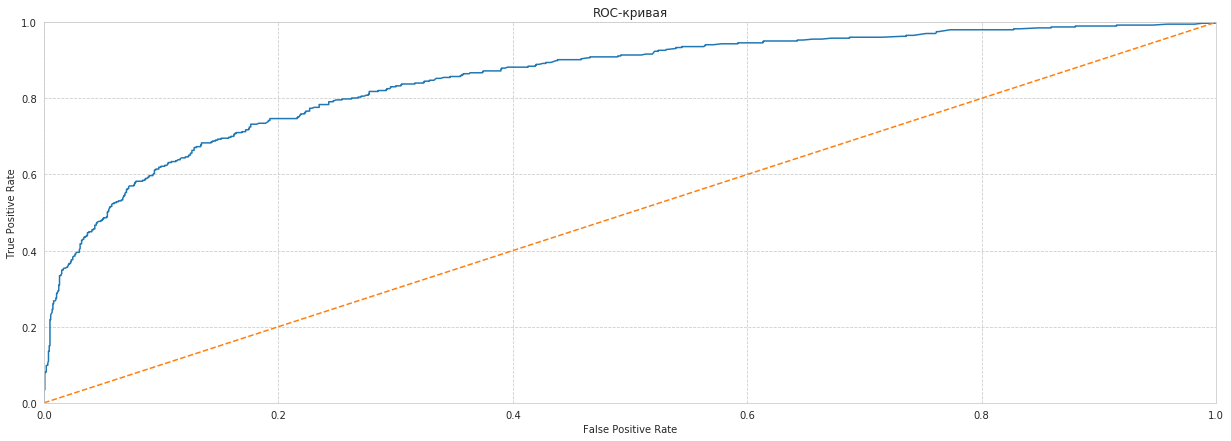

AUC-ROC:  0.8530094038568614


In [125]:
probabilities_one_valid = plot_ROC_curve(model, X_test, y_test)
print('AUC-ROC: ', roc_auc_score(y_test, probabilities_one_test))

# Выводы

Таким образом, мне удалось достигнуть значения метрики f1, равной 0.61 на тестовой выборке. 

Моя измененная выборка не дала результата, возможно, я не до конца довел преобразование, или сделал что-то избыточно. Делал я это, основываясь на kaggle (https://www.kaggle.com/currie32/predicting-fraud-with-tensorflow), но там были нейронки.